In [33]:
using FFTW, Plots, LinearAlgebra, SparseArrays, Printf, ApproxFun, LaTeXStrings, RecurrenceCoefficients, BenchmarkTools
import Base: diff, *

In [34]:
M = (a,b) ->  (x -> (b-a)/2*(x .+ (b+a)/(b-a)))
iM = (a,b) -> (x -> 2/(b-a)*(x .- (b+a)/2))

#15 (generic function with 1 method)

In [35]:
#used only to compare coefficients with those computed via standard orthogonalization
function HouseholderTri(A,b::Vector,k::Integer,flag=false)
    X = copy(A)
    (n,m) = size(X)
    Q,R = qr(hcat(b,rand(n,n-1)))
    Q = Q |> Array
    if Q[1,1]*b[1] < 0
        Q[:,1] *= -1
    end
    if k >= n
        out = HouseholderTri(Q'*X*Q |> copy,flag)
    else
        out = HouseholderTri(Q'*X*Q |> copy,k,flag)
    end
    if flag
        return Q*out[1], out[2]
    else
        return out
    end
end

HouseholderTri (generic function with 5 methods)

In [36]:
function HouseholderTri(X,flag::Bool)
   (n,m) = size(X)
   if flag
       Q = 1.0*Array(I,n,n)
   end
   for i = 1:n-1
        #Y = X[i+1:end,i:end]
        w = X[i+1:end,i]
        arg = w[1]/abs(w[1])
        w = w/arg
        w[1] = w[1] + norm(w)
        w = w/norm(w)
        X[i+1:end,i:end] = -(X[i+1:end,i:end] - 2.0*w*(w'*X[i+1:end,i:end]))/arg
        X[i:end,i+1:end] = -(X[i:end,i+1:end] - 2.0*(X[i:end,i+1:end]*w)*w')/arg
        if flag
            Q[1:end,i+1:end] = -(Q[1:end,i+1:end] - 2.0*(Q[1:end,i+1:end]*w)*w')/arg
        end
    end
    if flag
        return Q, SymTridiagonal(diag(X),diag(X,-1))
    else
        return SymTridiagonal(diag(X),diag(X,-1))
    end
    
end

HouseholderTri (generic function with 5 methods)

In [37]:
function HouseholderTri(X,k::Integer,flag=false)
   (n,m) = size(X)
   if k >= n
        return HouseholderTri(X,flag)
   end
   if flag
       Q = 1.0*Array(I,n,n)
   end
   for i = 1:k
        #Y = X[i+1:end,i:end]
        w = X[i+1:end,i]
        arg = w[1]/abs(w[1])
        w = w/arg
        w[1] = w[1] + norm(w)
        w = w/norm(w)
        X[i+1:end,i:end] = -(X[i+1:end,i:end] - 2.0*w*(w'*X[i+1:end,i:end]))/arg
        X[i:end,i+1:end] = -(X[i:end,i+1:end] - 2.0*(X[i:end,i+1:end]*w)*w')/arg
        if flag
            Q[1:end,i+1:end] = -(Q[1:end,i+1:end] - 2.0*(Q[1:end,i+1:end]*w)*w')/arg
        end
    end
    if flag
        return Q[:,1:k], SymTridiagonal(diag(X)[1:k],diag(X,-1)[1:k-1])
    else
        return SymTridiagonal(diag(X)[1:k],diag(X,-1)[1:k-1])
    end
    
end

HouseholderTri (generic function with 5 methods)

# Figures for paper

### Single interval case

In [38]:
h(x) = (exp(x)+1)/(4+x^2)

h (generic function with 1 method)

In [39]:
(a1int,b1int) = get_n_coeffs1int(h,50,-1.0,1.0;num_points₁=160,num_points₂=16);

In [40]:
(a1intn,b1intn) = get_n_coeffs1int(h,1000,1010,-1.0,1.0);

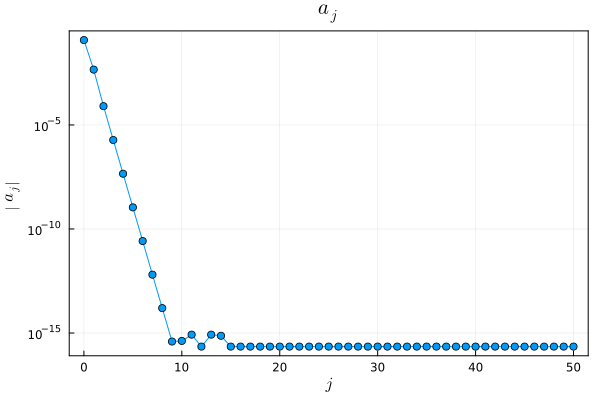

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423


In [41]:
plot(0:50,abs.(a1int).+eps(),yaxis=:log,label=:false,marker=:circle,framestyle=:box)
xlabel!(L"j")
ylabel!(L"\left|a_j\right|")
title!(L"a_j")

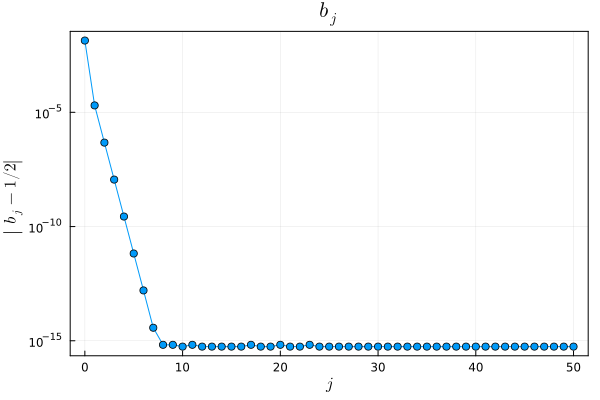

In [42]:
plot(0:50,abs.(b1int.-0.5).+eps(),yaxis=:log,label=:false,marker=:circle,framestyle=:box)
xlabel!(L"j")
ylabel!(L"\left|b_j-1/2\right|")
title!(L"b_j")

In [43]:
m = 801;

J = SymTridiagonal(zeros(m),fill(0.5,m-1));
E = eigen(J)
λ = E.values
wj = abs2.(E.vectors[1,:]);
lamvec = h.(λ)
wj .*= 1/2*lamvec

#λj = lamvec.*λ
W = Diagonal(λ);
#wws = vcat(wj);
T = HouseholderTri(W,sqrt.(wj),599);

In [44]:
a_gs1 = diag(T)[1:51];
b_gs1 = diag(T,-1)[1:51];

In [45]:
markershapes = filter((m->begin
                m in Plots.supported_markers()
            end), Plots._shape_keys)
p1 = plot(framestyle=:box,legend=:outerleft,legendtitle="PPI",size=(1000,300),margin=5Plots.mm)
xlabel!(L"j")
ylabel!("Error")
title!(L"a_j")
p2 = plot(framestyle=:box,legend=:outerleft,legendtitle="PPI",size=(1000,300),margin=5Plots.mm)
xlabel!(L"j")
ylabel!("Error")
title!(L"b_j")
for pc = 1:4
    n₁ = 10*2^(pc)
    n₂ = 2^(pc)
    (avec,bvec) = get_n_coeffs1int(h,50,-1.0,1.0; num_points₁=n₁, num_points₂=n₂)
    plot!(p1,0:50,abs.(avec-a_gs1).+eps(),yaxis=:log,marker=markershapes[pc],label=:2^pc)
    plot!(p2,0:50,abs.(bvec-b_gs1).+eps(),yaxis=:log,marker=markershapes[pc],label=:2^pc)
end

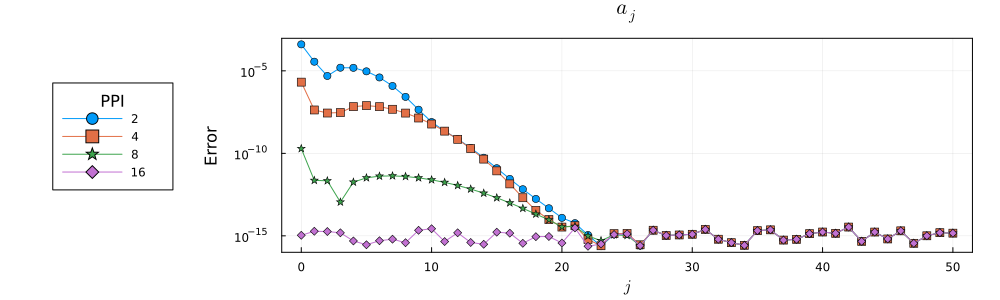

In [46]:
p1

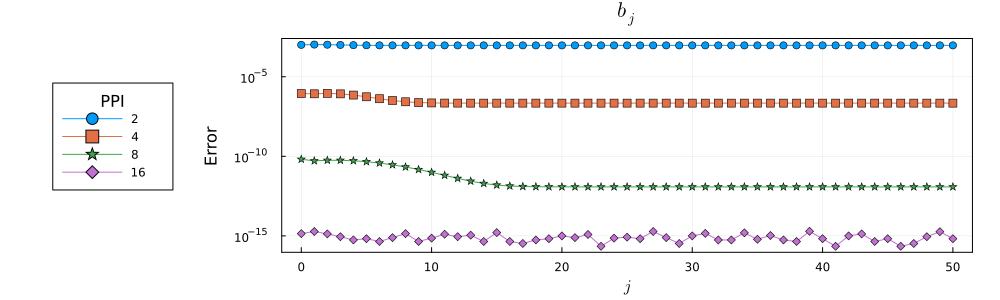

In [47]:
p2

In [48]:
p1 = plot(framestyle=:box,legend=:outerleft,legendtitle="PPI",size=(1000,300),margin=5Plots.mm)
xlabel!(L"j")
ylabel!("Error")
title!(L"a_j")
yticks!([10^-5, 10^-10, 10^-15])
p2 = plot(framestyle=:box,legend=:outerleft,legendtitle="PPI",size=(1000,300),margin=5Plots.mm)
xlabel!(L"j")
ylabel!("Error")
title!(L"b_j")
for pc = 1:4
    n₁ = 10*2^(pc)
    n₂ = 2^(pc)
    (avec,bvec) = get_n_coeffs1int(h,1000,1020,-1.0,1.0; num_points₁=n₁, num_points₂=n₂)
    plot!(p1,1000:1020,abs.(avec).+eps(),yaxis=:log,marker=markershapes[pc],label=:2^pc)
    plot!(p2,1000:1020,abs.(bvec.-1/2).+eps(),yaxis=:log,marker=markershapes[pc],label=:2^pc)
end

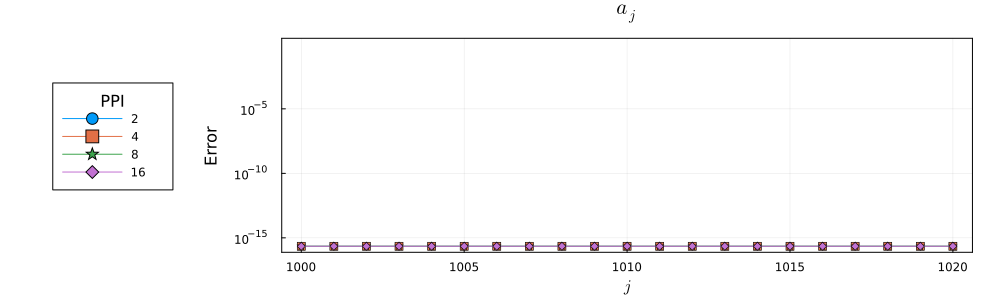

In [49]:
p1

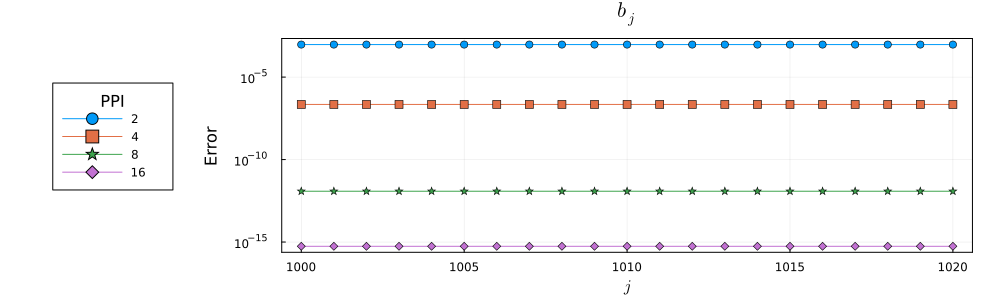

In [50]:
p2

### Double interval case

In [51]:
bands = [-1.8 -1.0; 2.0 3.0]

2×2 Matrix{Float64}:
 -1.8  -1.0
  2.0   3.0

In [52]:
@time begin
m = 801;
J = SymTridiagonal(zeros(m),[1/√2; fill(0.5,m-2)]);
E = eigen(J)
λ = E.values
wj = abs2.(E.vectors[1,:]);
a1 = bands[1,1]; b1 = bands[1,2]
a2 = bands[2,1]; b2 = bands[2,2]
w1 = wj
w2 = wj
w3 = wj
λ1 = M(a1,b1)(λ)
λ2 = M(a2,b2)(λ);
#ρ1 = (ComputeOrthoPoly(λ,ChebyT₁)*cs1) |> real
#ρ2 = (ComputeOrthoPoly(λ,ChebyT₂)*cs2) |> real
#w1 *= (b1-a1)/2
#w2 *= (b2-a2)/2
#w3 *= (b3-a3)/2
W = Diagonal(vcat(λ1,λ2));
wws = vcat(w1,w2);
T = HouseholderTri(W,sqrt.(wws),599);
end

 25.054285 seconds (193.90 k allocations: 92.694 GiB, 8.67% gc time, 0.15% compilation time)


599×599 SymTridiagonal{Float64, Vector{Float64}}:
 0.55     1.97611    ⋅         ⋅        …   ⋅         ⋅         ⋅ 
 1.97611  0.583707  0.632172   ⋅            ⋅         ⋅         ⋅ 
  ⋅       0.632172  0.936042  1.87157       ⋅         ⋅         ⋅ 
  ⋅        ⋅        1.87157   0.173046      ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅        0.480886      ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅        …   ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅        …   ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
 ⋮                                      ⋱                      
  ⋅        ⋅   

In [53]:
a_gs2 = diag(T)[1:51];
b_gs2 = diag(T,-1)[1:51];

In [54]:
p1 = plot(framestyle=:box,legend=:outerleft,legendtitle="PPI",size=(1000,300),margin=5Plots.mm)
xlabel!(L"j")
ylabel!("Error")
title!(L"a_j")
p2 = plot(framestyle=:box,legend=:outerleft,legendtitle="PPI",size=(1000,300),margin=5Plots.mm)
xlabel!(L"j")
ylabel!("Error")
title!(L"b_j")
nmat = [10*ones(size(bands,1)) ones(size(bands,1))]
for pc = 1:4
    nmat = 2^(pc)*[10*ones(size(bands,1)) ones(size(bands,1))] .|> Int128
    #println(nmat)
    @time begin
    (avec,bvec) = get_n_coeffs(bands,50;nmat)
    end
    plot!(p1,0:50,abs.(avec-a_gs2).+eps(),yaxis=:log,marker=markershapes[pc],label=:2^pc)
    plot!(p2,0:50,abs.(bvec-b_gs2).+eps(),yaxis=:log,marker=markershapes[pc],label=:2^pc)
end

  8.038666 seconds (28.61 M allocations: 1.574 GiB, 3.43% gc time, 99.63% compilation time)
  0.085810 seconds (253.35 k allocations: 76.696 MiB, 45.71% gc time)
  0.197119 seconds (685.66 k allocations: 288.503 MiB, 10.95% gc time)
  0.905318 seconds (2.18 M allocations: 1.096 GiB, 4.03% gc time)


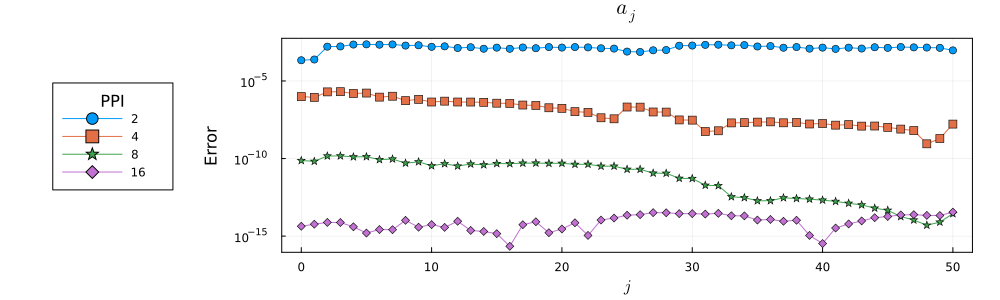

In [55]:
p1

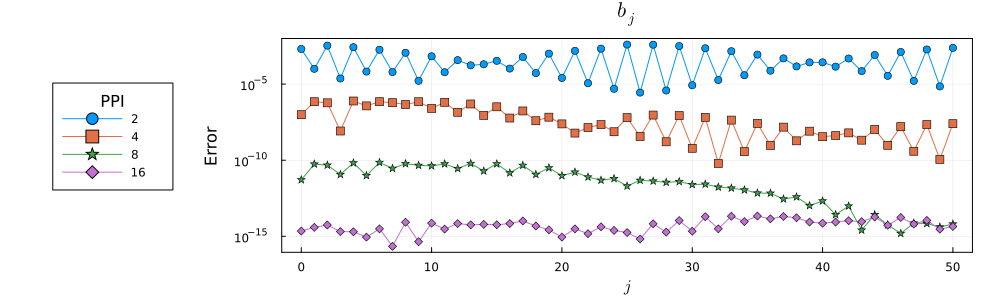

In [56]:
p2

In [57]:
nmat = [120*ones(size(bands,1)) 15*ones(size(bands,1))] .|> Int128
@time (avec,bvec) = get_n_coeffs(bands,50;nmat);

  0.486188 seconds (1.40 M allocations: 667.336 MiB, 5.05% gc time)


#### Timing comparison with an $N^2$ method

In [58]:
# The following is ported from Gatuschi's "lanczos.m" from the text "Orthogonal Polynomials: Computation and Approximation" "
# % LANCZOS Lanczos algorithm.
# %
# %    Given the discrete inner product whose nodes are contained 
# %    in the first column, and whose weights are contained in the 
# %    second column, of the nx2 array xw, the call ab=LANCZOS(n,xw)
# %    generates the first n recurrence coefficients ab of the 
# %    corresponding discrete orthogonal polynomials. The n alpha-
# %    coefficients are stored in the first column, the n beta-
# %    coefficients in the second column, of the nx2 array ab.
# %
# %    The script is adapted from the routine RKPW in
# %    W.B. Gragg and W.J. Harrod, ``The numerically stable 
# %    reconstruction of Jacobi matrices from spectral data'', 
# %    Numer. Math. 44 (1984), 317-335.
function lanczos(N, xw)
    Ncap = size(xw, 1)
    if N <= 0 || N > Ncap
        error("N out of range")
    end
    p0 = xw[:, 1]
    p1 = zeros(Ncap)
    p1[1] = xw[1, 2]
    for n in 1:Ncap-1
        pn = xw[n+1, 2]
        gam = 1.0
        sig = 0.0
        t = 0.0
        xlam = xw[n+1, 1]
        for k in 1:n+1
            rho = p1[k] + pn
            tmp = gam * rho
            tsig = sig
            if rho <= 0
                gam = 1.0
                sig = 0.0
            else
                gam = p1[k] / rho
                sig = pn / rho
            end
            tk = sig * (p0[k] - xlam) - gam * t
            p0[k] = p0[k] - (tk - t)
            t = tk
            if sig <= 0
                pn = tsig * p1[k]
            else
                pn = t^2 / sig
            end
            tsig = sig
            p1[k] = tmp
        end
    end
    ab = (p0[1:N], sqrt.(p1[2:N]))
    return ab
end


lanczos (generic function with 1 method)

In [61]:
mvec = 200:200:3800
t1 = zeros(length(mvec)); t2 = zeros(length(mvec))
typemat = ones(size(bands,1)) .|> Int64
for (i,mm) in enumerate(mvec)
    t11 = @belapsed get_n_coeffs_no_circ(bands,$mm,typemat,j->x->1)
    t22 = @belapsed begin
    J = SymTridiagonal(zeros($mm),[1/√2; fill(0.5,$mm-2)]);
    E = eigen(J)
    λ = E.values
    wj = abs2.(E.vectors[1,:]);
    a1 = bands[1,1]; b1 = bands[1,2]
    a2 = bands[2,1]; b2 = bands[2,2]
    w1 = wj
    w2 = wj
    λ1 = M(a1,b1)(λ)
    λ2 = M(a2,b2)(λ);
    λs = vcat(λ1,λ2)
    wws = vcat(w1,w2);
    xw = [λs wws];
    lanczos($mm+1,xw)
    end
    t1[i] = t11; t2[i] = t22
end

1.0003750606262473e-12
1.0005650551846405e-12
1.0011002877209465e-12
1.0012600780672828e-12
1.0018919640821711e-12
1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0003750606262473e-12
1.0005650551846405e-12
1.0011002877209465e-12
1.0012600780672828e-12
1.0018919640821711e-12
1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0003750606262473e-12
1.0005650551846405e-12
1.0011002877209465e-12
1.0012600780672828e-12
1.0018919640821711e-12
1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12

1.0011002877209465e-12
1.0012600780672828e-12
1.0018919640821711e-12
1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0003750606262473e-12
1.0005650551846405e-12
1.0011002877209465e-12
1.0012600780672828e-12
1.0018919640821711e-12
1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0003750606262473e-12
1.0005650551846405e-12
1.0011002877209465e-12
1.0012600780672828e-12
1.0018919640821711e-12
1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0003750606262473e-12


1.0018919640821711e-12
1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0003750606262473e-12
1.0005650551846405e-12
1.0011002877209465e-12
1.0012600780672828e-12
1.0018919640821711e-12
1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0003750606262473e-12
1.0005650551846405e-12
1.0011002877209465e-12
1.0012600780672828e-12
1.0018919640821711e-12
1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0003750606262473e-12
1.0005650551846405e-12
1.0011002877209465e-12


1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12
1.0205575479806262e-12
1.0212377607348056e-12
1.0214096327659646e-12
1.0219448653022708e-12
1.0221167373334296e-12
1.0227486233483179e-12
1.022872168640186e-12
1.023546340551954e-12
1.0236668654226161e-12
1.0242162561833238e-12
1.0243384800409142e-12
1.0250179376897921e-

1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-12
1.0621956479603406e-12
1.0622708665129169e-12
1.0629510792670965e-12
1.0630927470861986e-12
1.0636370408861216e-12
1.0638406273399403e-12
1.0644733156542114e-12
1.0646081403315192e-12
1.0651932098177191e-12
1.0653288367944099e-12
1.0659244777548296e-12
1.06604802304669

1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12
1.0205575479806262e-12
1.0212377607348056e-12
1.0214096327659646e-12
1.0219448653022708e-12
1.0221167373334296e-12
1.0227486233483179e-12
1.022872168640186e-12
1.023546340551954e-12
1.0236668654226161e-12
1.0242162561833238e-12
1.0243384800409142e-1

1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-12
1.0621956479603406e-12
1.0622708665129169e-12
1.0629510792670965e-12
1.0630927470861986e-12
1.0636370408861216e-12
1.0638406273399403e-12
1.0644733156542114e-12
1.0646081403315192e-12
1.0651932098177191e-12
1.0653288367944099e-12
1.065924477754829

1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12
1.0205575479806262e-12
1.0212377607348056e-12
1.0214096327659646e-12
1.0219448653022708e-12
1.0221167373334296e-12
1.0227486233483179e-12
1.022872168640186e-12
1.023546340551954e-12
1.0236668654226161e-12
1.0242162561833238e-1

1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-12
1.0621956479603406e-12
1.0622708665129169e-12
1.0629510792670965e-12
1.0630927470861986e-12
1.0636370408861216e-12
1.0638406273399403e-12
1.0644733156542114e-12
1.0646081403315192e-12
1.0651932098177191e-12
1.065328836794409

1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12
1.0205575479806262e-12
1.0212377607348056e-12
1.0214096327659646e-12
1.0219448653022708e-12
1.0221167373334296e-12
1.0227486233483179e-12
1.022872168640186e-12
1.023546340551954e-12
1.0236668654226161e-1

1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-12
1.0621956479603406e-12
1.0622708665129169e-12
1.0629510792670965e-12
1.0630927470861986e-12
1.0636370408861216e-12
1.0638406273399403e-12
1.0644733156542114e-12
1.0646081403315192e-12
1.0651932098177191

1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12
1.0205575479806262e-12
1.0212377607348056e-12
1.0214096327659646e-12
1.0219448653022708e-12
1.0221167373334296e-12
1.0227486233483179e-12
1.022872168640186e-12
1.023546340551954e-1

1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-12
1.0621956479603406e-12
1.0622708665129169e-12
1.0629510792670965e-12
1.0630927470861986e-12
1.0636370408861216e-12
1.0638406273399403e-12
1.0644733156542114e-12
1.0646081403315192e

1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12
1.0205575479806262e-12
1.0212377607348056e-12
1.0214096327659646e-12
1.0219448653022708e-12
1.0221167373334296e-12
1.0227486233483179e-12
1.022872168640186e-

1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-12
1.0621956479603406e-12
1.0622708665129169e-12
1.0629510792670965e-12
1.0630927470861986e-12
1.0636370408861216e-12
1.0638406273399403e-12
1.0644733156542114e

1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12
1.0205575479806262e-12
1.0212377607348056e-12
1.0214096327659646e-12
1.0219448653022708e-12
1.0221167373334296e-12
1.0227486233483179e

1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-12
1.0621956479603406e-12
1.0622708665129169e-12
1.0629510792670965e-12
1.0630927470861986e-12
1.0636370408861216e-12
1.0638406273399403e

1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12
1.0205575479806262e-12
1.0212377607348056e-12
1.0214096327659646e-12
1.0219448653022708e-12
1.0221167373334296e-

1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-12
1.0621956479603406e-12
1.0622708665129169e-12
1.0629510792670965e-12
1.0630927470861986e-12
1.0636370408861216e

1.0050976430251776e-12
1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12
1.0205575479806262e-12
1.0212377607348056e-12
1.0214096327659646e-12
1.0219448653022708e-

1.0466753345807795e-12
1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-12
1.0621956479603406e-12
1.0622708665129169e-12
1.0629510792670965e-12
1.0630927470861986e

1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12
1.0205575479806262e-12
1.0212377607348056e-12
1.0214096327659646e-1

1.0460192851962457e-12
1.0466753345807795e-12
1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-12
1.0621956479603406e-12
1.0622708665129169e-12
1.0629510792670965e

1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12
1.0205575479806262e-12
1.0212377607348056e-12

1.0459078215892006e-12
1.0460192851962457e-12
1.0466753345807795e-12
1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-12
1.0621956479603406e-12
1.0622708665129169e

1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12
1.0205575479806262e-12

1.045269894731901e-12
1.0459078215892006e-12
1.0460192851962457e-12
1.0466753345807795e-12
1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-12
1.0621956479603406e-

1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12

1.0450829205947132e-12
1.045269894731901e-12
1.0459078215892006e-12
1.0460192851962457e-12
1.0466753345807795e-12
1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-

1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12

1.044460850948744e-12
1.0450829205947132e-12
1.045269894731901e-12
1.0459078215892006e-12
1.0460192851962457e-12
1.0466753345807795e-12
1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-1

1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12


1.044426691246932e-12
1.044460850948744e-12
1.0450829205947132e-12
1.045269894731901e-12
1.0459078215892006e-12
1.0460192851962457e-12
1.0466753345807795e-12
1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12

1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12


1.0437816852774313e-12
1.044426691246932e-12
1.044460850948744e-12
1.0450829205947132e-12
1.045269894731901e-12
1.0459078215892006e-12
1.0460192851962457e-12
1.0466753345807795e-12
1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12

1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12


1.0435811192448183e-12
1.0437816852774313e-12
1.044426691246932e-12
1.044460850948744e-12
1.0450829205947132e-12
1.045269894731901e-12
1.0459078215892006e-12
1.0460192851962457e-12
1.0466753345807795e-12
1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12

1.0018919640821711e-12
1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12


1.0430217233388668e-12
1.0435811192448183e-12
1.0437816852774313e-12
1.044426691246932e-12
1.044460850948744e-12
1.0450829205947132e-12
1.045269894731901e-12
1.0459078215892006e-12
1.0460192851962457e-12
1.0466753345807795e-12
1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-1

1.0012600780672828e-12
1.0018919640821711e-12
1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12


1.042886096362176e-12
1.0430217233388668e-12
1.0435811192448183e-12
1.0437816852774313e-12
1.044426691246932e-12
1.044460850948744e-12
1.0450829205947132e-12
1.045269894731901e-12
1.0459078215892006e-12
1.0460192851962457e-12
1.0466753345807795e-12
1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12

1.0011002877209465e-12
1.0012600780672828e-12
1.0018919640821711e-12
1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12


1.0423146187714016e-12
1.042886096362176e-12
1.0430217233388668e-12
1.0435811192448183e-12
1.0437816852774313e-12
1.044426691246932e-12
1.044460850948744e-12
1.0450829205947132e-12
1.045269894731901e-12
1.0459078215892006e-12
1.0460192851962457e-12
1.0466753345807795e-12
1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-1

1.0005650551846405e-12
1.0011002877209465e-12
1.0012600780672828e-12
1.0018919640821711e-12
1.0020396727436844e-12
1.0026715587585731e-12
1.002795104050441e-12
1.0034451125925632e-12
1.0035444945147858e-12
1.0041559926865357e-12
1.004254430727131e-12
1.004836668568451e-12
1.0050976430251776e-12
1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12


1.0420944200009515e-12
1.0423146187714016e-12
1.042886096362176e-12
1.0430217233388668e-12
1.0435811192448183e-12
1.0437816852774313e-12
1.044426691246932e-12
1.044460850948744e-12
1.0450829205947132e-12
1.045269894731901e-12
1.0459078215892006e-12
1.0460192851962457e-12
1.0466753345807795e-12
1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-1

1.0831396074638839e-12
1.0838741877997654e-12
1.0839022122710036e-12
1.0844825623490697e-12
1.0847078580803044e-12
1.0852702744074612e-12
1.0854663098082661e-12
1.0860015423445718e-12
1.0862459044846677e-12
1.0869019538692014e-12
1.0870013357914236e-12
1.0875607316973751e-12
1.0876480319347749e-12
1.0883342855313654e-12
1.088469912508056e-12
1.089080466798179e-12
1.0896781842981777e-12
1.089917638253814e-12
1.0904347482628863e-12
1.0906066202940449e-12
1.0911901795696418e-12
1.0912895614918644e-12
1.0920181009853348e-12
1.0921174829075568e-12
1.0927493689224454e-12
1.0928487508446677e-12
1.0934262692778533e-12
1.0935936106772038e-12
1.0942959102614499e-12
1.0943165724559985e-12
1.0949673361034225e-12
1.0951452489769928e-12
1.0957590124646471e-12
1.0958946394413375e-12
1.0965023620865801e-12
1.096674234117739e-12
1.0972819567629819e-12
1.0973088485762675e-12
1.098013224700092e-12
1.0981850967312514e-12
1.098741472215997e-12
1.098871719067415e-12
1.0994610360209357e-12
1.1001287895376415

1.1247988503920319e-12
1.1249012527354597e-12
1.1254968936958795e-12
1.1257412558359756e-12
1.1262281616329902e-12
1.1264000336641488e-12
1.1270319196790373e-12
1.1272521184494871e-12
1.1278115143554387e-12
1.1278988145928382e-12
1.1285246597653148e-12
1.1287456136410665e-12
1.129357914112199e-12
1.1299074464551505e-12
1.1300898899605295e-12
1.13060095912719e-12
1.1307607494735261e-12
1.1313926354884143e-12
1.1315645075195733e-12
1.1321480667951703e-12
1.1323441021959748e-12
1.132927661471572e-12
1.133147860242022e-12
1.1337465216236474e-12
1.1337802093846457e-12
1.1344632065896243e-12
1.1345696204299657e-12
1.135181873707017e-12
1.1353175006837076e-12
1.1359856317530643e-12
1.1360487686208181e-12
1.1367531447446427e-12
1.1368041999275742e-12
1.1374360859424621e-12
1.1376442030280895e-12
1.1381311088251043e-12
1.1383815118076112e-12
1.1389046626590945e-12
1.1396130974739144e-12
1.1396978492309218e-12
1.140346347562441e-12
1.1405182195936e-12
1.1411501056084882e-12
1.1412374058458877e-1

1.005632875561484e-12
1.0058409926471112e-12
1.0064245519227083e-12
1.0066447506931587e-12
1.0071316564901735e-12
1.0073276918909782e-12
1.007935414536221e-12
1.0080770823553231e-12
1.0087512542670908e-12
1.0088763097695617e-12
1.009389455475801e-12
1.0100086934768906e-12
1.0102198309837238e-12
1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12
1.0169012082950731e-12
1.0170005902172951e-12
1.0176566396018292e-12
1.0178043482633424e-12
1.0183577033268829e-12
1.0184872894611621e-12
1.0190708487367592e-12
1.0196753621844713e-12
1.0199335049963176e-12
1.0204823294280493e-12
1.0205575479806262e-12
1.0212377607348056e-12
1.0214096327659646e-12
1.0219448653022708e-12
1.0221167373334296e-

1.0468230432422932e-12
1.0473341124089533e-12
1.0474697393856443e-12
1.048077462030887e-12
1.048279538274103e-12
1.0489310570268285e-12
1.049053611242988e-12
1.0497046108608183e-12
1.0501930268684361e-12
1.0503860418480348e-12
1.051011887020512e-12
1.0511595956820252e-12
1.0517431549576225e-12
1.0518908636191358e-12
1.0524985862643786e-12
1.0526100498714236e-12
1.0533144259952485e-12
1.053371522020591e-12
1.0540426735111536e-12
1.0541842008541228e-12
1.054848696873105e-12
1.0549971606399198e-12
1.0555565565458716e-12
1.0557163468922075e-12
1.0563240695374505e-12
1.0564234514596725e-12
1.0570553374745606e-12
1.0571788827664286e-12
1.0578349321509626e-12
1.0579222323883622e-12
1.0586507718818326e-12
1.0587184393813951e-12
1.059394018266713e-12
1.0599369050930862e-12
1.060110287334848e-12
1.0606968670316507e-12
1.0608204123235189e-12
1.0614643800232299e-12
1.0616362520543888e-12
1.0621956479603406e-12
1.0622708665129169e-12
1.0629510792670965e-12
1.0630927470861986e-12
1.0636370408861216e

1.0883342855313654e-12
1.088469912508056e-12
1.089080466798179e-12
1.0896781842981777e-12
1.089917638253814e-12
1.0904347482628863e-12
1.0906066202940449e-12
1.0911901795696418e-12
1.0912895614918644e-12
1.0920181009853348e-12
1.0921174829075568e-12
1.0927493689224454e-12
1.0928487508446677e-12
1.0934262692778533e-12
1.0935936106772038e-12
1.0942959102614499e-12
1.0943165724559985e-12
1.0949673361034225e-12
1.0951452489769928e-12
1.0957590124646471e-12
1.0958946394413375e-12
1.0965023620865801e-12
1.096674234117739e-12
1.0972819567629819e-12
1.0973088485762675e-12
1.098013224700092e-12
1.0981850967312514e-12
1.098741472215997e-12
1.098871719067415e-12
1.0994610360209357e-12
1.1001287895376415e-12
1.1003157636748292e-12
1.1008993229504257e-12
1.1009624598181799e-12
1.1016185092027135e-12
1.1018145446035178e-12
1.10237394050947e-12
1.1025699759102739e-12
1.1031052084465801e-12
1.103258957950505e-12
1.1038938643865985e-12
1.1040651700887815e-12
1.1046455201668475e-12
1.1047758614064286e-1

1.1299074464551505e-12
1.1300898899605295e-12
1.13060095912719e-12
1.1307607494735261e-12
1.1313926354884143e-12
1.1315645075195733e-12
1.1321480667951703e-12
1.1323441021959748e-12
1.132927661471572e-12
1.133147860242022e-12
1.1337465216236474e-12
1.1337802093846457e-12
1.1344632065896243e-12
1.1345696204299657e-12
1.135181873707017e-12
1.1353175006837076e-12
1.1359856317530643e-12
1.1360487686208181e-12
1.1367531447446427e-12
1.1368041999275742e-12
1.1374360859424621e-12
1.1376442030280895e-12
1.1381311088251043e-12
1.1383815118076112e-12
1.1389046626590945e-12
1.1396130974739144e-12
1.1396978492309218e-12
1.140346347562441e-12
1.1405182195936e-12
1.1411501056084882e-12
1.1412374058458877e-12
1.141820965121485e-12
1.141920347043707e-12
1.1426005597978862e-12
1.1426878600352857e-12
1.1433499502622307e-12
1.143491618081333e-12
1.1441253918594743e-12
1.1442401590522135e-12
1.1449529357225165e-12
1.1449903990100221e-12
1.1456102033400876e-12
1.1457699936864237e-12
1.1463777163316663e-12


Excessive output truncated after 524339 bytes.

1.010761104362441e-12
1.0109813031328912e-12
1.0114923722995517e-12
1.0117125710700017e-12
1.0123686204545358e-12
1.012419675637467e-12
1.0130998883916463e-12
1.0132596787379824e-12
1.0138281359075512e-12
1.014029079492815e-12
1.0145278781983275e-12
1.0147282554546156e-12
1.0153299372574469e-12
1.0155259726582512e-12
1.01607328687938e-12
1.016245158910539e-12


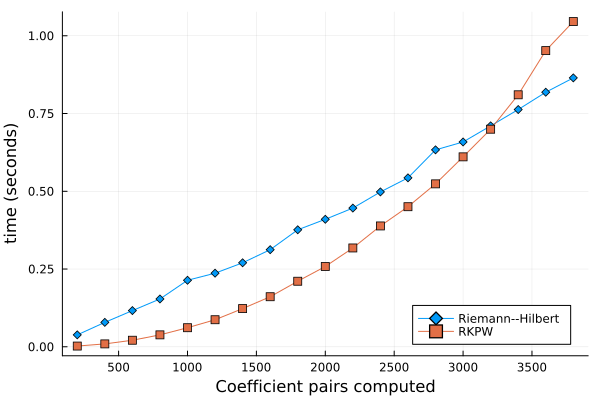

In [62]:
p1 = plot(mvec,t1,marker=:diamond,legend=:bottomright,label=:"Riemann--Hilbert")
plot!(mvec,t2,marker=:square,label=:"RKPW")
xlabel!("Coefficient pairs computed")
ylabel!("time (seconds)")

### Triple interval case

In [27]:
bands = [0.1 1.1; 2.0 3.0; 3.5 4.0]

3×2 Matrix{Float64}:
 0.1  1.1
 2.0  3.0
 3.5  4.0

In [28]:
@time begin
m = 801;
J = SymTridiagonal([0.5; zeros(m-1)],fill(0.5,m-1));
E = eigen(J)
λ = E.values
wj = abs2.(E.vectors[1,:]);
a1 = bands[1,1]; b1 = bands[1,2]
a2 = bands[2,1]; b2 = bands[2,2]
a3 = bands[3,1]; b3 = bands[3,2]
w1 = wj
w2 = wj
w3 = wj
λ1 = M(a1,b1)(λ)
λ2 = M(a2,b2)(λ);
λ3 = M(a3,b3)(λ)
#ρ1 = (ComputeOrthoPoly(λ,ChebyT₁)*cs1) |> real
#ρ2 = (ComputeOrthoPoly(λ,ChebyT₂)*cs2) |> real
w1 *= (b1-a1)/2
w2 *= (b2-a2)/2
w3 *= (b3-a3)/2
W = Diagonal(vcat(λ1,λ2,λ3));
wws = vcat(w1,w2,w3);
T = HouseholderTri(W,sqrt.(wws),599);
end

 86.417988 seconds (196.53 k allocations: 239.059 GiB, 11.26% gc time, 0.04% compilation time)


599×599 SymTridiagonal{Float64, Vector{Float64}}:
 2.215    1.20997    ⋅         ⋅        …   ⋅         ⋅         ⋅ 
 1.20997  2.14616   0.902151   ⋅            ⋅         ⋅         ⋅ 
  ⋅       0.902151  2.61785   0.975235      ⋅         ⋅         ⋅ 
  ⋅        ⋅        0.975235  1.32017       ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅        0.785434      ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅        …   ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅        …   ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
 ⋮                                      ⋱                      
  ⋅        ⋅   

In [29]:
a_gs3 = diag(T)[1:51];
b_gs3 = diag(T,-1)[1:51];

In [30]:
p1 = plot(framestyle=:box,legend=:outerleft,legendtitle="PPI",size=(1000,300),margin=5Plots.mm)
xlabel!(L"j")
ylabel!("Error")
title!(L"a_j")
p2 = plot(framestyle=:box,legend=:outerleft,legendtitle="PPI",size=(1000,300),margin=5Plots.mm)
xlabel!(L"j")
ylabel!("Error")
title!(L"b_j")
for pc = 1:4
    nmat = 2^(pc)*[10*ones(size(bands,1)) ones(size(bands,1))] .|> Int128
    h(j) = x->1
    @time (avec,bvec) = get_n_coeffs(bands,50,"V";nmat)  
    plot!(p1,0:50,abs.(avec-a_gs3).+eps(),yaxis=:log,marker=markershapes[pc],label=:2^pc)
    plot!(p2,0:50,abs.(bvec-b_gs3).+eps(),yaxis=:log,marker=markershapes[pc],label=:2^pc)
end

  0.612933 seconds (1.32 M allocations: 113.426 MiB, 94.83% compilation time)
  0.126205 seconds (688.34 k allocations: 174.496 MiB, 11.85% gc time)
  0.738266 seconds (1.77 M allocations: 652.660 MiB, 31.97% gc time)
  3.179662 seconds (5.31 M allocations: 2.470 GiB, 2.97% gc time)


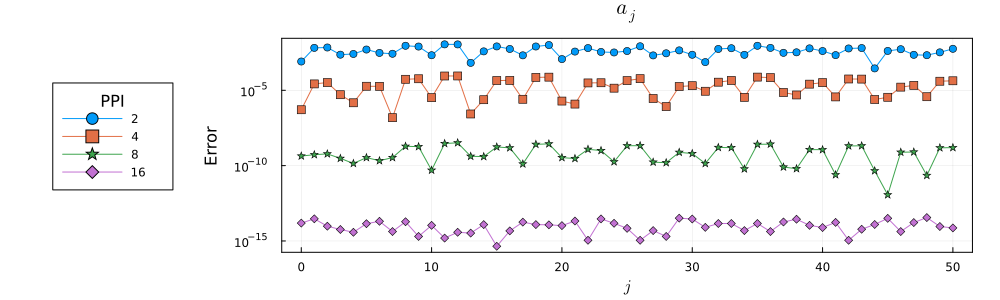

In [31]:
p1

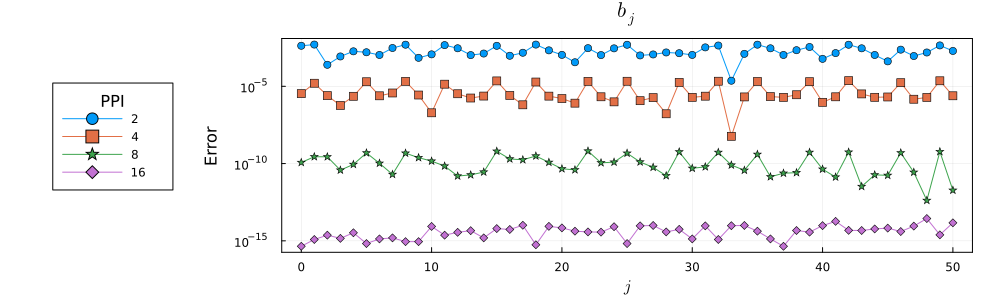

In [32]:
p2

### Quadruple interval case!

In [33]:
bands = [-3.2 -2.2; 0.1 1.1; 2.0 3.0; 3.5 4.0]

4×2 Matrix{Float64}:
 -3.2  -2.2
  0.1   1.1
  2.0   3.0
  3.5   4.0

In [34]:
h(j) = x->1
typemat = [1 2 3 4]

1×4 Matrix{Int64}:
 1  2  3  4

In [35]:
function w(j)
    if typemat[j] == 1 #T
        return z -> h(j)(z)/(√(bands[j,2]-z)*√(z-bands[j,1]))
    elseif typemat[j] == 2 #U
        return z -> h(j)(z)*(√(bands[j,2]-z)*√(z-bands[j,1]))
    elseif typemat[j] == 3 #V
        return z -> h(j)(z)*(√(z-bands[j,1])/√(bands[j,2]-z))
    else #W
        return z -> h(j)(z)*(√(bands[j,2]-z)/√(z-bands[j,1]))
    end
end

w (generic function with 1 method)

In [36]:
p1 = plot(xlabel=L"x",ylabel=L"w(x)")
for j = 1:4
    xgrid = bands[j,1]:0.01:bands[j,2]
    plot!(xgrid,w(j).(xgrid),label=:false,color=:blue,fill=(0,"lightblue"))
end

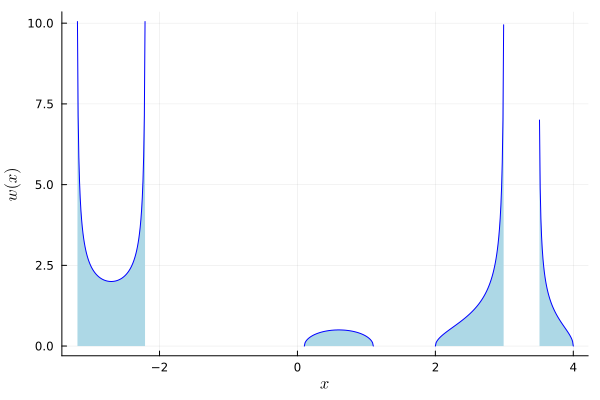

In [37]:
p1

In [38]:
@time begin
m = 801;
a1 = bands[1,1]; b1 = bands[1,2]
a2 = bands[2,1]; b2 = bands[2,2]
a3 = bands[3,1]; b3 = bands[3,2]
a4 = bands[4,1]; b4 = bands[4,2]

J = SymTridiagonal(zeros(m),[1/√2; fill(0.5,m-2)]);
E = eigen(J)
λ = E.values
wj = abs2.(E.vectors[1,:]);
w1 = wj
λ1 = M(a1,b1)(λ)

J = SymTridiagonal(zeros(m),fill(0.5,m-1));
E = eigen(J)
λ = E.values
wj = abs2.(E.vectors[1,:]);
w2 = wj
λ2 = M(a2,b2)(λ);
w2 *= (b2-a2)^2/8

J = SymTridiagonal([0.5; zeros(m-1)],fill(0.5,m-1));
E = eigen(J)
λ = E.values
wj = abs2.(E.vectors[1,:]);
w3 = wj
λ3 = M(a3,b3)(λ)
w3 *= (b3-a3)/2

J = SymTridiagonal([-0.5; zeros(m-1)],fill(0.5,m-1));
E = eigen(J)
λ = E.values
wj = abs2.(E.vectors[1,:]);
w4 = wj
λ4 = M(a4,b4)(λ)
w4 *= (b4-a4)/2

W = Diagonal(vcat(λ1,λ2,λ3,λ4));
wws = vcat(w1,w2,w3,w4);
T = HouseholderTri(W,sqrt.(wws),599)
end

200.683691 seconds (61.13 k allocations: 454.250 GiB, 10.84% gc time, 0.01% compilation time)


599×599 SymTridiagonal{Float64, Vector{Float64}}:
 -0.183333  2.7815     ⋅          ⋅        …    ⋅         ⋅        ⋅ 
  2.7815    0.501588  1.09548     ⋅             ⋅         ⋅        ⋅ 
   ⋅        1.09548   0.680727   2.13525        ⋅         ⋅        ⋅ 
   ⋅         ⋅        2.13525   -0.136488       ⋅         ⋅        ⋅ 
   ⋅         ⋅         ⋅         2.01816        ⋅         ⋅        ⋅ 
   ⋅         ⋅         ⋅          ⋅        …    ⋅         ⋅        ⋅ 
   ⋅         ⋅         ⋅          ⋅             ⋅         ⋅        ⋅ 
   ⋅         ⋅         ⋅          ⋅             ⋅         ⋅        ⋅ 
   ⋅         ⋅         ⋅          ⋅             ⋅         ⋅        ⋅ 
   ⋅         ⋅         ⋅          ⋅             ⋅         ⋅        ⋅ 
   ⋅         ⋅         ⋅          ⋅        …    ⋅         ⋅        ⋅ 
   ⋅         ⋅         ⋅          ⋅             ⋅         ⋅        ⋅ 
   ⋅         ⋅         ⋅          ⋅             ⋅         ⋅        ⋅ 
  ⋮                                     

In [39]:
a_gs4 = diag(T)[1:51];
b_gs4 = diag(T,-1)[1:51];

In [40]:
markershapes = filter((m->begin
                m in Plots.supported_markers()
            end), Plots._shape_keys)
p1 = plot(framestyle=:box,legend=:outerleft,legendtitle="PPI",size=(1000,300),margin=5Plots.mm)
xlabel!(L"n")
ylabel!("Error")
title!(L"a_n")
p2 = plot(framestyle=:box,legend=:outerleft,legendtitle="PPI",size=(1000,300),margin=5Plots.mm)
xlabel!(L"n")
ylabel!("Error")
title!(L"b_n")
for pc = 1:4
    nmat = 2^(pc)*[10*ones(size(bands,1)) ones(size(bands,1))] .|> Int128
    @time (avec,bvec) = get_n_coeffs_mixed(bands,50,typemat;nmat)
    plot!(p1,0:50,abs.(avec-a_gs4).+eps(),yaxis=:log,marker=markershapes[pc],label=:2^pc)
    plot!(p2,0:50,abs.(bvec-b_gs4).+eps(),yaxis=:log,marker=markershapes[pc],label=:2^pc)
end

  0.732681 seconds (2.28 M allocations: 198.846 MiB, 92.87% compilation time)
  0.230343 seconds (1.28 M allocations: 310.235 MiB, 14.30% gc time)
  1.128075 seconds (3.26 M allocations: 1.133 GiB, 3.76% gc time)
  7.013348 seconds (9.60 M allocations: 4.389 GiB, 1.29% gc time)


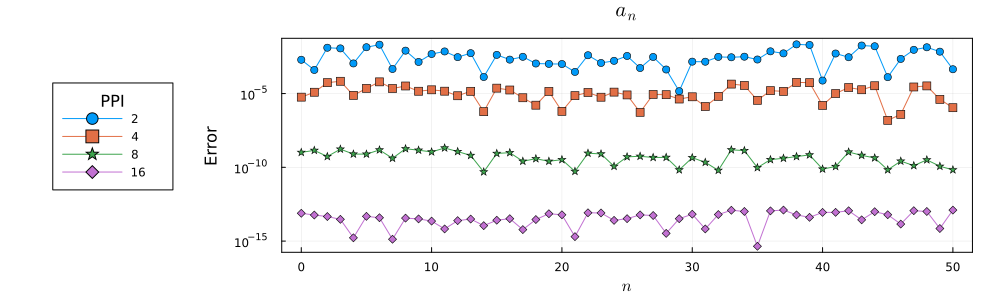

In [41]:
p1

In [42]:
savefig(p1,"test1.pdf")

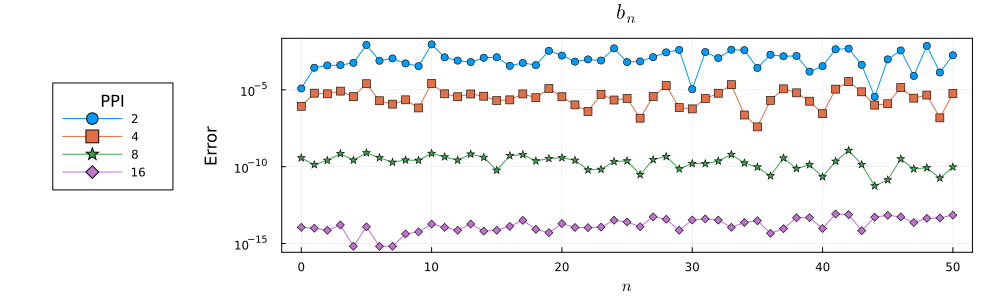

In [43]:
p2

In [44]:
savefig(p2,"test2.pdf")

## Toda lattice application

In [45]:
anima = Animation()
animb = Animation()

tvec = 0:0.1:11.5
max_coeffs=10
amat = zeros(length(tvec),max_coeffs+1); bmat = zeros(length(tvec),max_coeffs+1)
for (j,t) in enumerate(tvec)
    h(x) = exp(t*x)
    (avec,bvec) = get_n_coeffs1int(h,max_coeffs,-1.0,1.0)
    amat[j,:] = avec
    bmat[j,:] = bvec
    
    plot(0:max_coeffs,avec,seriestype=:scatter,legend=:false)
    ylims!(-0.01, 1)
    xlabel!(L"j")
    ylabel!(L"a_j")
    title!(L"t=%$t")
    frame(anima)
    
    plot(0:max_coeffs,bvec,seriestype=:scatter,legend=:false)
    ylims!(0, 0.51)
    xlabel!(L"j")
    ylabel!(L"b_j")
    title!(L"t=%$t")
    frame(animb)
end

1.2350007845442764e-12
-9.268605861080152e-15
-1.2438634957703352e-12
1.7592432882858836e-14
2.670728743346772e-12
-1.737758887730652e-13
-1.284940963937967e-11
-2.802624723378629e-13
1.307571484870178e-12
-1.4068182285320939e-14
-2.758666594133264e-12
2.437471620033123e-13
-2.5189974799843224e-12
7.188814386165823e-13
1.1489854234028638e-12
6.599704113000432e-14
2.113405816675891e-12
-4.014719545090427e-14
1.88303987648121e-11
1.2134741424079751e-13
-1.6321657997076513e-11
3.713456383254331e-13
-1.4958813108193326e-11
9.176872014333977e-13
2.609331316209073e-12
2.5274467532350427e-13
-2.411091905939276e-11
7.774757189161041e-13
5.391143781821839e-11
4.4825504633978434e-14
1.088078333637271e-12
-6.17411530937195e-14
5.222767496827384e-11
2.948276871617678e-13
-2.813582605355873e-12
2.306805145958759e-13
-4.085956286137616e-11
4.19214466885923e-13
4.550076551078063e-12
-7.03883537688679e-13
-1.4004577217978067e-12
-1.7899426405886108e-13
-1.4526251525383173e-11
1.160018012498626e-12
3.1

2.3579824554260453e-12
2.29146220520466e-12
-2.9181309253462958e-12
-1.1184119064187008e-12
-8.855798652119693e-12
-1.293711442498421e-12
7.06476583233374e-12
1.3195437426881822e-13
9.144874171987347e-12
-1.0285760534111733e-12
-5.388489565878904e-12
8.641994359536387e-14
6.2139322629937736e-12
3.7770835417564506e-13
-7.062477644742929e-12
7.613612272176422e-13
-1.1197279854671672e-9
6.507287997415779e-11
1.725856723872733e-11
1.33362758745789e-11
1.4587033167099167e-11
2.1833659367576097e-12
-2.637035203942302e-12
9.944794954213154e-14
1.5250481536135573e-13
-3.1836228171399547e-12
1.2654221318328135e-12
-3.8743044506171215e-12
-4.151168814585651e-12
1.031418049515561e-12
-1.4201093648792575e-12
-2.803864999448075e-12
1.3051514483338354e-11
-4.196120403446892e-12
-7.245844393423133e-12
-1.1362984557063093e-12
5.07024441053443e-12
-5.273689654936922e-13
-2.441387974128171e-9
1.579067882024102e-11
1.9642103170737995e-10
-6.821372079608442e-12
-1.0731662704282396e-13
2.412204365106997e-1

9.883100471660617e-9
5.947321072078332e-13
6.079958222057879e-11
2.2405771199645073e-11
6.265970612691701e-11
-1.7192422845653943e-11
-3.103117693217105e-11
-4.3566719532670086e-12
1.0527326309388289e-11
-1.5896811428246682e-12
-1.4932550542190489e-12
-4.545295523719491e-12
-1.9800363026462194e-12
-5.287883885940753e-12
-3.6935353943886346e-11
4.065422931484451e-12
3.4869957370654384e-11
-7.556247301092947e-12
-5.999218802043446e-12
6.279084862586831e-12
-2.0275267469541667e-11
2.3179540394266173e-12
8.899115278280061e-9
-2.1482893203619037e-10
-3.017719957443035e-10
-6.804814440508844e-11
-7.715126715081233e-11
-3.307170113975418e-13
-9.422682198875802e-12
1.678318434255007e-12
1.2264607827579262e-11
2.744538396047268e-12
1.6694314997714874e-11
-2.2601428989214285e-12
-4.108521866718111e-11
1.0130182598771808e-11
1.8033929821045612e-11
-1.6894200891478253e-12
6.68615171773447e-12
-2.2933625657377058e-12
-2.6902654254384984e-12
2.4748004460001376e-12
-1.1567334559756902e-11
5.450626240

-8.850000429984879e-11
-1.3998606173912596e-11
7.767101993522538e-11
3.591642090857844e-12
5.778931337780937e-12
-7.988790237309242e-12
-5.421912625247768e-11
-5.702169405772616e-12
9.121678402212783e-11
5.874513727791929e-12
-6.17286898645626e-11
-8.577131566780638e-12
-3.654350878118377e-7
-9.061421855464176e-10
-8.189634643469099e-9
-1.1311421802873114e-10
3.3213692873795733e-10
-4.245183306459605e-11
-1.1213921097074373e-11
-3.124424552813923e-12
-1.972142590532842e-12
-5.787036211679668e-12
1.7338445010322725e-11
-1.2519508699819506e-11
-3.9440016527451515e-11
-6.6421656884213525e-12
2.925313441135418e-11
-1.0940058613551952e-11
-1.0013300527666621e-11
-1.8078533195003917e-12
-9.15129280924018e-11
-1.6103203127254896e-11
1.4306947162578252e-10
1.1747864099220236e-11
3.6852742905335823e-7
1.4611827570805835e-9
5.7563783828571486e-9
7.75084607299408e-11
3.214172076345241e-10
-5.2461918724878554e-11
-4.322556233974575e-11
-5.499864011957764e-12
-1.532428208740607e-11
-2.7957349144110

-1.0249223984651942e-7
5.0337465767848835e-8
4.352681499169903e-8
-9.415452996514202e-10
-1.5363144158286956e-9
1.46239514342215e-10
2.4154873006236796e-10
-1.5213598825643213e-10
-2.085056791667329e-11
-4.2748047171541663e-11
3.331304115811843e-10
2.1358114439520825e-10
-2.338513813511388e-10
1.3239219713593379e-10
4.5526301515909664e-10
-1.6494242042966886e-10
-3.5692475193314416e-10
-6.105040829586165e-12
1.5402573449000015e-10
2.7363678237131133e-11
-7.014458706915821e-11
-5.710747349790852e-12
-1.0825134185009789e-6
-4.700911919065954e-8
1.2669358716954923e-7
-2.0351412422514655e-9
-4.8829459705986865e-9
1.9867565724260484e-10
1.0675430185087452e-9
-2.6014980814688445e-10
-5.361879969354589e-10
2.1085102195342576e-10
2.283041282086937e-10
3.9277509890963723e-11
-2.1125863982139363e-10
-6.893915379482639e-11
3.9420939306332143e-10
-2.4618245643366433e-11
-9.576060448305845e-11
-1.24388434027566e-11
-1.5240620999575167e-10
-8.502683292770588e-11
4.369503788743918e-10
-3.230433072171

1.2982062544319459e-9
1.7105277718768212e-10
2.8193422059450374e-9
-1.532444014393407e-10
-9.683812326151479e-10
-1.684797434892551e-10
-1.2466745880745305e-9
1.540765167761448e-10
-2.782921168795466e-9
-5.315186119588573e-10
8.272023700114581e-5
-4.507344083266822e-7
-6.572705215365587e-7
3.372533620278115e-8
3.665146574560464e-8
-3.073264146399919e-9
-3.791443355087701e-9
-4.865105915943475e-10
4.079035534938398e-11
-8.237172325072145e-10
2.633498825653037e-9
2.0853683429732527e-10
-1.2838723850249778e-10
-6.330810696640974e-11
-1.1612447981711927e-9
1.695093988546017e-10
-5.481460268145245e-10
2.2341853418080623e-10
6.246443936087599e-11
-3.6755398906067446e-10
-2.432825397911489e-10
-8.102650184675845e-11
4.3758152187933774e-5
-1.2598491636967095e-8
9.483954878095055e-7
-2.9234832481001198e-8
-8.563279409499033e-8
7.194238616510953e-9
8.652785342621584e-9
2.4799738071537355e-9
1.635066697523652e-9
1.5026155429789362e-9
2.6803406380223892e-9
5.901776532951866e-10
1.3863189859702764e

┌ Info: Saved animation to 
│   fn = /home/cade/Research/NumericRH/toda1inta.gif
└ @ Plots /home/cade/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/cade/Research/NumericRH/toda1inta.gif")
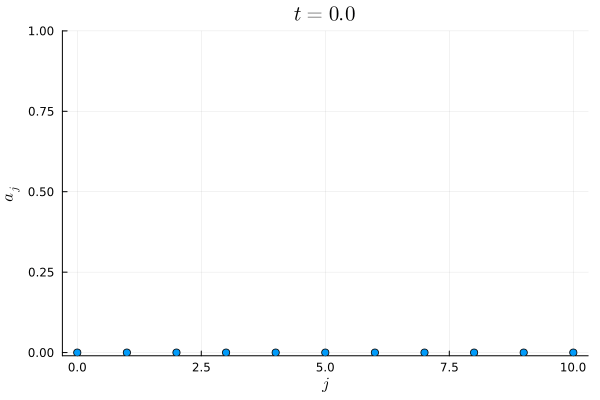

In [46]:
gif(anima,"toda1inta.gif")

┌ Info: Saved animation to 
│   fn = /home/cade/Research/NumericRH/toda1intb.gif
└ @ Plots /home/cade/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/cade/Research/NumericRH/toda1intb.gif")
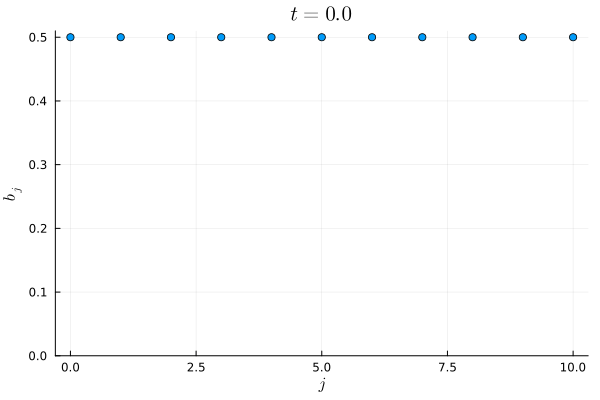

In [47]:
gif(animb,"toda1intb.gif")

In [48]:
p1 = plot()
xlabel!(L"t")
ylabel!(L"a_j(t)",legend=:outerleft,size=(1000,300),framestyle=:box,margin=5Plots.mm)

p2 = plot()
xlabel!(L"t")
ylabel!(L"b_j(t)",legend=:outerleft,size=(1000,300),framestyle=:box,margin=5Plots.mm)

styles = intersect([:solid, :dash, :dot, :dashdot, :dashdotdot], Plots.supported_styles())
styles = reshape(styles, 1, length(styles))


for j = 0:max_coeffs
    plot!(p1,tvec,amat[:,j+1],label=L"a_{%$j}",linestyle=styles[j%5+1])
end

for j = 0:max_coeffs
    plot!(p2,tvec,bmat[:,j+1],label=L"b_{%$j}",linestyle=styles[j%5+1])
end

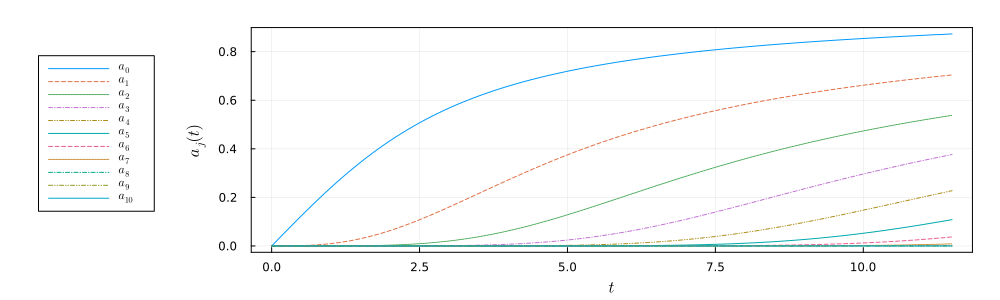

In [49]:
p1

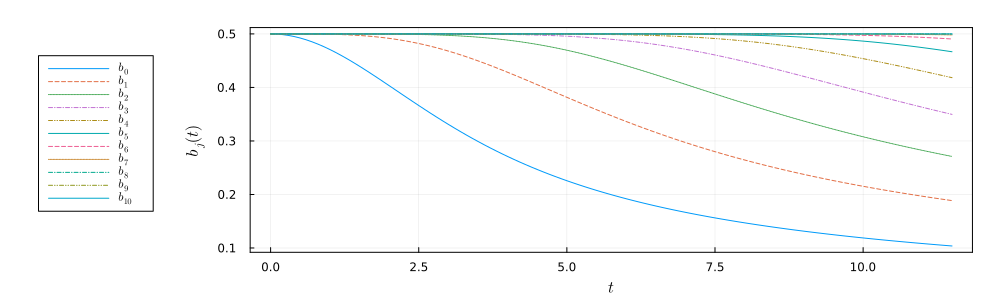

In [50]:
p2

### Double interval

In [51]:
bands = [-3.0 -2.0; 2.0 3.0]

2×2 Matrix{Float64}:
 -3.0  -2.0
  2.0   3.0

In [52]:
(avec,bvec) = get_n_coeffs(bands,50)

([1.0689366058969085e-14, -9.145740356591964e-15, 8.257561936891839e-15, -7.541399332555654e-15, 1.5535005109856782e-14, -1.1655365362168174e-14, -3.887756982584018e-15, 3.915892843786684e-15, -5.692249683186934e-15, 5.807121718188438e-15  …  1.1517171800401616e-13, -9.518770356076334e-14, 9.026583780536932e-14, -1.2046390407517357e-13, 1.1532172843833047e-13, -1.0643994424132922e-13, 1.229018874858888e-13, -1.1490828170858767e-13, 1.0991702701415457e-13, -1.0281159965655357e-13], [2.5248762345905167, 0.7010146707647743, 2.4638609640816127, 0.5060828873956567, 2.4989294611047788, 0.5001927002611907, 2.4999646733348944, 0.5000065595383754, 2.499998770254797, 0.5000002322586335  …  0.5000000000000006, 2.4999999999999987, 0.5000000000000006, 2.500000000000001, 0.5000000000000003, 2.5000000000000044, 0.5000000000000003, 2.5, 0.5000000000000007, 2.5000000000000018])

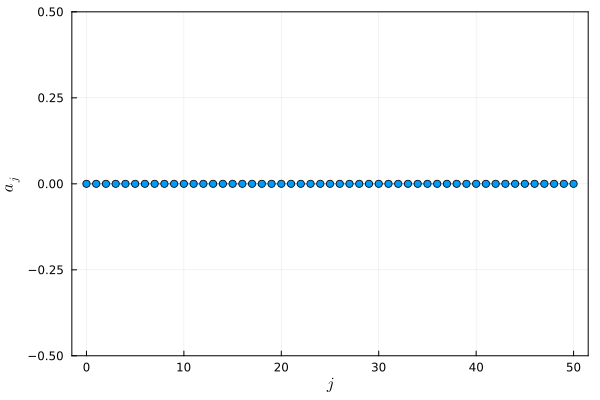

In [53]:
plot(0:50,avec,marker=:circle,legend=:false,framestyle=:box,ylims=(-0.5,0.5))
xlabel!(L"j")
ylabel!(L"a_j")

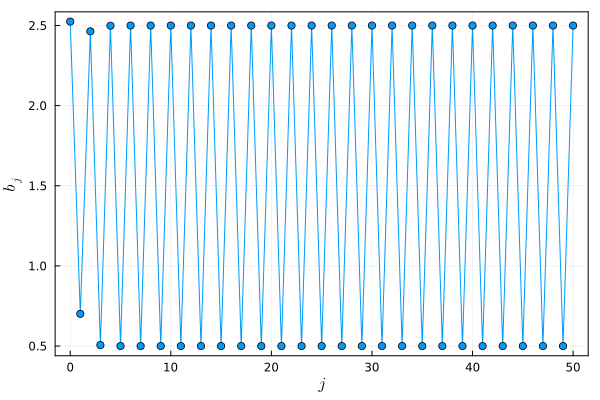

In [54]:
plot(0:50,bvec,marker=:circle,legend=:false,framestyle=:box)
xlabel!(L"j")
ylabel!(L"b_j")

In [55]:
anima = Animation()
animb = Animation()

tvec = 0:0.025:4.5
max_coeffs = 10
amat = zeros(length(tvec),max_coeffs+1); bmat = zeros(length(tvec),max_coeffs+1)
for (j,t) in enumerate(tvec)
    h(j) = x -> exp(t*x)
    (avec,bvec) = get_n_coeffs(bands,max_coeffs,"T",h)
    amat[j,:] = avec
    bmat[j,:] = bvec
    
    plot(0:max_coeffs,avec,seriestype=:scatter,legend=:false)
    ylims!(-2.25, bands[end,2])
    xlabel!(L"j")
    ylabel!(L"a_j")
    title!(L"t=%$t")
    frame(anima)
    
    plot(0:max_coeffs,bvec,seriestype=:scatter,legend=:false)
    ylims!(0, 2.75)
    xlabel!(L"j")
    ylabel!(L"b_j")
    title!(L"t=%$t")
    frame(animb)
end

-3.293390961238464e-13
1.4337719349331592e-12
-1.1956264551137879e-13
1.010667068460261e-12
1.4898998354307746e-13
-1.3006210727026082e-12
-9.39917367125399e-14
1.160939489957426e-12
-1.6458586405158115e-13
6.493849395035463e-12
2.0580962506945667e-14
-1.1537937396556284e-12
4.800304479509777e-14
-1.542078283854983e-12
1.688039606638905e-13
-1.4421129223987301e-12
1.6697134879078772e-13
-1.7387838904325914e-12
5.41159138356282e-14
1.563762537833593e-12
-3.4807130983582654e-13
4.274785200764719e-12
1.0499614502841808e-13
1.2842328198180466e-12
-6.495390703538005e-14
9.255085976334948e-12
3.725032447144212e-13
6.978298888762272e-12
-2.6769638842720065e-13
1.4149707829679071e-12
-3.315221921484236e-13
1.0314614560554227e-12
-5.8437125894578474e-15
1.1003524955229004e-12
-3.9634385180626843e-13
1.5266548706992504e-11
9.452652838951003e-14
1.2864004934433918e-12
6.910015156566695e-13
-1.0096272590194831e-12
-1.5031110266130814e-12
1.787444252817835e-11
1.4318192804148429e-12
-5.345206763376

3.857526180550706e-12
3.042506406637933e-13
1.5029108594586203e-12
-3.3106441259214227e-12
-1.414069597561631e-12
-2.2144696689275183e-15
8.226892705511863e-13
-3.9837697290897485e-12
2.762771024956687e-12
-6.643624679265358e-12
-2.7708863852646717e-12
-1.3654915736125846e-13
-1.691091533644311e-12
-2.340258258141046e-12
1.6247020692201e-12
1.992207091970374e-13
-1.2120923267895972e-12
2.4419293186805853e-11
-1.5477118020449014e-12
1.4743083593052981e-13
2.4859709008621483e-12
-1.66014168220518e-13
-2.4348313686564133e-12
2.0224206941009597e-13
-2.9045909534900798e-12
1.591265187610338e-12
2.8826521070773485e-12
1.1782876964288155e-13
-1.1706051243458417e-12
2.946265930556854e-12
1.1502259000933148e-12
1.2874643444239363e-13
2.348581372278838e-13
-4.340011947007167e-12
-6.198502669664913e-14
1.4467981732090909e-11
1.4258458087621782e-12
-1.6023891254815967e-12
-1.3382462499967732e-12
-9.665897103166966e-14
-6.462405689057443e-13
3.5176947794344656e-12
-1.2577676366822831e-12
3.31308596

-9.591483399090784e-11
5.407781804128083e-13
5.3899563715991504e-12
-1.212187553632854e-11
-5.2646884674345384e-12
1.3558310839932307e-13
8.681279371930257e-12
-1.0848067000556066e-11
-8.733492188101861e-12
-7.018512401963571e-13
1.5069536427073203e-12
-1.8505944417484534e-11
-1.6093033719934826e-12
2.289190361293136e-13
-1.0643579277379712e-11
2.873387251075143e-11
1.0693907467350638e-11
5.629658699204322e-13
2.8905540622083643e-12
-7.099904694403193e-12
-2.0818434474438468e-11
-9.231943339107546e-10
1.9897152020948285e-11
-2.0599925945933996e-12
6.0925916579557974e-12
-1.0210186499421973e-11
-5.973763652369835e-12
-7.313601310364485e-13
-5.8698149531164664e-12
-2.0219647774699394e-12
5.758885093503836e-12
-1.837839119754273e-13
5.069193682968667e-12
-1.8773663473107446e-11
-5.0156862549756354e-12
-9.730699647377151e-14
-1.1127545610965159e-11
8.398474740671073e-12
1.1165700284137288e-11
7.829986408545675e-13
-3.495029897732136e-12
2.5159669193925202e-11
4.177040380113202e-11
2.150054

-3.3029448342180915e-11
-3.364305824215846e-10
-1.0882751585250232e-10
-3.5353549205292684e-13
-8.491062493644217e-13
-8.165020904619583e-12
-2.1048696763809872e-13
7.221324569637836e-12
4.278135897128752e-12
-1.3395786386323847e-11
-4.2904544167574e-12
-2.81320335374547e-13
6.702970097901678e-12
6.509732022852448e-12
-6.581412649687129e-12
-6.028134961825632e-13
3.5038916606537443e-12
-2.2315974019295932e-11
1.5570229396070024e-10
-1.320849235621845e-9
-1.3534989039341925e-10
1.707125084086047e-12
2.1921864140907932e-12
-4.203734212591866e-12
-2.45620682208356e-12
-6.362633514573584e-14
-8.946970437765847e-13
4.1019400766026546e-12
1.002519388434733e-12
2.6332011131045137e-13
4.430541843871141e-12
-1.629157015607724e-11
-4.273160244482786e-12
-2.557027058563688e-14
-2.2643235973265113e-12
-4.034269721349347e-11
2.1212089552667525e-12
8.6308840690326e-14
-7.276246661905269e-12
1.711687847376419e-11
-5.51279579613287e-11
-6.161232400092572e-9
4.8638924854280295e-11
-2.9352018300874945e-

9.851436597140316e-12
-3.830855752053939e-11
6.696803238442577e-10
2.54713783937205e-8
-3.353102636756661e-10
2.2374408262216114e-13
-9.06779791192073e-12
9.404125539793368e-11
9.035922992031838e-12
4.606365444264242e-13
-1.1252994964879632e-12
-1.866972533870508e-12
1.0656394624778059e-12
3.0840571251810866e-13
1.7658049525025327e-11
-5.810958725131369e-11
-1.7623127413009e-11
-2.5831970067595593e-13
1.7911769508657702e-11
-1.1954569569176028e-10
-1.7918786611517345e-11
2.491622345529883e-13
-8.649943365611876e-12
1.0509042632943526e-10
-2.126908404151549e-9
5.1922041357885214e-8
2.9322528831143976e-9
-3.054325073598444e-12
-5.64800234233125e-12
8.684597529874884e-11
5.262330266895608e-12
1.7048587843024694e-14
7.2242121230433935e-12
-6.880081880112391e-11
-6.884034980006942e-12
2.8503969237677445e-13
5.8616395102433105e-12
-2.3340039681447322e-11
-6.144379648968101e-12
-1.2885569516450183e-13
-1.752109769215154e-14
-2.733642455408985e-11
4.0549970639415015e-12
3.719398026465211e-11
-

-1.0464228926170502e-11
6.929866738137001e-13
-1.3311403455431455e-11
-2.854475384375946e-12
1.2912574552620444e-11
-6.266269156313e-13
-6.683187841321917e-12
1.56121552892931e-11
7.600112146476128e-12
3.7609601694045805e-13
-4.2443475032582203e-13
-6.560312363450493e-11
-3.828060997515514e-10
6.628824554078548e-8
-6.933219025734119e-10
3.8141084270551303e-11
-3.3229526666028485e-13
-4.332474925397692e-11
3.5382725678362765e-12
-9.60643972743044e-13
5.1850972454583525e-12
-8.282591565551738e-11
-5.939914917849306e-12
6.432585620287187e-12
-1.4262604329210961e-11
4.0084022383553666e-11
1.4401502923292043e-11
6.153536313247328e-12
-1.698454884136975e-11
7.922473907926586e-11
1.6418037020885642e-11
6.444085778582975e-14
-1.3575518630780918e-11
5.171125855637542e-11
-5.785869032865811e-11
-1.877524192340595e-7
-6.337556913526257e-10
-7.948614211027154e-11
-8.520833684687829e-14
-7.68110318518344e-11
2.3720763093533634e-12
-6.657372919535154e-12
5.8770656938355626e-12
-6.186344101625815e-11

-3.0234581113660136e-8
7.487729027807846e-7
2.998366808677055e-8
-3.5923674628465565e-11
-6.353713351040236e-12
2.1799382273411203e-10
1.4543746126596067e-11
-1.7424515481954776e-13
3.191850198721181e-12
7.578652799845042e-11
1.3482762924144669e-12
-6.433422199548168e-12
5.787318038438422e-12
-6.79472237430703e-11
-6.541363358614832e-12
-1.1313774786403597e-11
1.8523851389582757e-11
-7.866836185879676e-11
-2.3487892189120248e-11
9.83752671776209e-12
-6.94648319395457e-13
7.884207048130642e-11
1.0733169008914302e-8
-2.3612268028067179e-7
-5.9695255520045754e-9
-2.236964387922509e-10
1.007488256071283e-11
-1.1786404054424837e-10
-1.213428662164506e-11
-7.42275863186388e-12
-6.480490035331238e-12
-2.8683629863410812e-11
1.019785650298373e-11
-8.499028355761198e-12
2.7368951649851497e-12
-7.510213739861358e-11
-4.71951635955007e-12
1.227883858118955e-11
-1.475282855548212e-11
8.65475064695615e-11
1.6248922782477937e-11
-8.993311313533208e-12
-5.872482293421299e-12
3.014963977592017e-11
3.9

4.374812439271446e-11
-2.966553679694318e-10
-4.493061341246159e-11
1.2700076991978527e-11
1.9089742860996314e-11
4.4455198346195883e-11
-1.817889220665074e-11
-7.012678670500794e-12
-3.5125587902220533e-12
5.4043511310061996e-11
4.236641469956593e-7
-1.154979103364847e-6
-6.118183005246291e-8
-1.1181403313585221e-11
-4.53752822663667e-12
-3.022882185722859e-10
-3.2107737826832116e-11
2.0300899208561474e-11
3.117552479759303e-12
1.885628607038072e-11
4.3564874479962696e-12
1.6763188555597394e-13
7.0573009071081144e-12
1.9158175396398886e-10
-8.675926765426279e-12
3.5836969696798866e-12
-4.139781316379711e-11
4.926614515756258e-11
3.4525976791824696e-11
1.6650971088783347e-11
-1.2698694136953792e-12
4.59258933769526e-10
-5.566326939189332e-7
2.6963889740653987e-6
7.568445297370126e-8
4.644750774056277e-11
4.3739159455059224e-11
9.616732347356875e-11
-5.593215594603682e-11
1.195643443114064e-12
7.770176773474657e-12
1.4447169124371056e-10
-5.048577469028523e-12
-1.05515028454052e-12
1.40

-1.0091731711470563e-6
1.2698388574570867e-10
-1.8986502127016634e-11
-6.648102884644239e-10
-4.3533625818585595e-11
-8.714191632406778e-13
-8.803882041752483e-11
8.202021946102433e-10
9.641978450636088e-11
-6.943122437494397e-12
4.82870250621229e-11
-1.0862271465270456e-9
-5.143503882618135e-11
-2.0530332364724786e-11
2.618549810083651e-11
-6.222718206153642e-10
-2.9403256717539376e-11
-9.170536978965416e-13
9.781135270153543e-11
-5.761178055406969e-10
2.1449507277937816e-6
-8.011813154698317e-6
-6.797645171695184e-7
2.722800649795399e-9
5.122931346025202e-10
-1.893987505784209e-9
-6.443492272768151e-11
-2.1301665901150617e-11
2.803003363591474e-11
-6.679827433999978e-10
-4.6886956843229053e-11
-1.3671156778025243e-11
5.607904302366199e-11
2.2639893476026805e-11
-4.646144562124979e-11
8.495805166116495e-12
-7.98164821933557e-11
-3.4556926288022755e-11
8.708774387448062e-11
-2.201671869689176e-11
-2.966135378415109e-11
-1.9041392714502497e-10
-1.1848079830410075e-6
3.2833813348590693e-

-1.4752957276747357e-11
-2.7741352234312022e-11
-2.336882942740994e-10
3.098898519206326e-9
2.36206198371201e-10
5.460747273675896e-11
2.69711163336517e-10
1.5593830177016913e-9
-6.706378541917888e-6
2.57945785045728e-6
1.1382310559203977e-6
2.8453214880126702e-8
1.2070130778690514e-9
4.013968195261945e-9
-1.2540074447726162e-10
-4.9904324696116783e-11
4.332070354455594e-11
-8.808067999043609e-10
-4.55075022404906e-11
-2.1468265670909926e-12
1.1603785873153682e-10
-1.9234019469242015e-10
-1.1437783587260688e-10
-4.5601344226058765e-11
4.4647560103602494e-10
-1.0407284421610156e-9
-4.4452553538375853e-10
3.2974153423653484e-12
4.582201604660062e-10
-3.2070643218847253e-9
-1.455377995225246e-6
-7.677570143213324e-5
-1.7077153255045872e-6
3.9275932306516274e-9
2.5062152759649916e-9
4.823004971519189e-9
9.726400079970318e-11
7.947618504447963e-11
3.5266362028470016e-10
3.7629614901791136e-10
-3.486865084139086e-10
-2.3101772407240837e-11
2.525662280692856e-10
-1.0617304986748397e-9
-2.3239

-7.098673254524209e-9
5.7612896164392625e-8
5.401935926728702e-9
-3.6202296384012986e-11
1.3830118358572724e-9
-1.0532819304701264e-8
-1.387272764474634e-9
-3.196455619001436e-11
-1.412051691382372e-9
6.061094024796916e-9
1.4055119634432568e-9
-5.728045707147195e-11
-1.055282452449335e-9
6.2668108375700554e-9
1.0740625396757171e-9
-7.967826817671598e-11
2.6291337140167166e-10
-6.585355707332801e-9
-4.2167224443796994e-5
-0.0004895357569833836
-3.90467874526135e-6
2.4670860997067858e-8
-2.9065351636365127e-9
6.3399042749065e-8
8.554921777242141e-10
3.4009626014550784e-11
-1.257852887590466e-9
6.246558305692509e-9
1.260653602427903e-9
-9.480754308650893e-11
-2.886315942191641e-9
2.4907510208970128e-9
2.8904573102754062e-9
-1.21765670373424e-10
-2.2274277278192294e-9
3.817383989393223e-9
2.236328428837389e-9
-5.3222568828574135e-11
-7.749969358129692e-10
-2.6525466506676056e-9
-9.491904515836875e-5
0.00015650144197449796
1.2210365852943753e-5
-3.198510404955823e-8
-5.237435673396204e-10
-

9.41361200467768e-10
-1.102781361293252e-10
3.6396705475502606e-9
5.736504325311537e-10
0.00015583247438732446
0.0011016445252747427
6.262437765572205e-5
1.1315100853465383e-7
2.2250716767353174e-8
7.637966187025225e-8
2.7446818133212353e-9
-1.7763058794049727e-10
7.630241849197745e-9
-3.377076155483659e-8
-7.610246727259837e-9
-7.228969845089082e-11
-2.147898689611598e-9
1.2264480422973688e-8
2.1449337129605416e-9
-1.6706061971592442e-12
-7.044435010205881e-9
-2.529413363206529e-10
7.017891418273373e-9
7.615013762033902e-11
-2.373903621085667e-9
3.0025438824170145e-9
-2.2116116908612575e-5
0.0012891227132631198
3.1322728781498932e-6
-2.92288984046212e-7
-2.7129772460788932e-9
2.576419339615705e-7
5.39478358207125e-9
-2.550124995893864e-10
1.4336133486291557e-8
-2.5304048523566968e-8
-1.4375217445637511e-8
-1.6319201648702012e-10
4.662961829202948e-9
7.952052067225178e-10
-4.6540493646530114e-9
-1.5420302012174197e-10
4.963392534371251e-9
-1.32066849324418e-8
-4.95559747243789e-9
-4.52

┌ Info: Saved animation to 
│   fn = /home/cade/Research/NumericRH/toda2inta.gif
└ @ Plots /home/cade/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/cade/Research/NumericRH/toda2inta.gif")
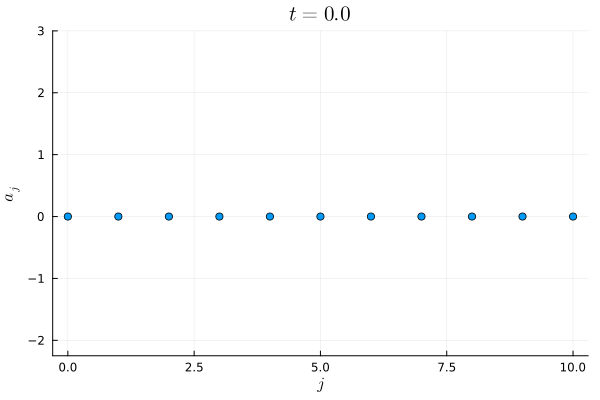

In [56]:
gif(anima,"toda2inta.gif")

┌ Info: Saved animation to 
│   fn = /home/cade/Research/NumericRH/toda2intb.gif
└ @ Plots /home/cade/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/cade/Research/NumericRH/toda2intb.gif")
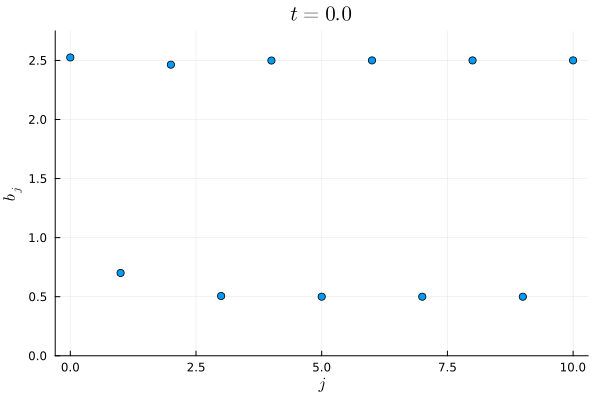

In [57]:
gif(animb,"toda2intb.gif")

In [58]:
p1 = plot(legend=:outerleft,size=(1000,300),framestyle=:box,margin=5Plots.mm)
xlabel!(L"t")
ylabel!(L"a_j(t)")

p2 = plot(legend=:outerleft,size=(1000,300),framestyle=:box,margin=5Plots.mm)
xlabel!(L"t")
ylabel!(L"b_j(t)")

for j = 0:max_coeffs
    plot!(p1,tvec,amat[:,j+1],label=L"a_{%$j}",linestyle=styles[j%5+1])
end

for j = 0:max_coeffs
    plot!(p2,tvec,bmat[:,j+1],label=L"b_{%$j}",linestyle=styles[j%5+1])
end

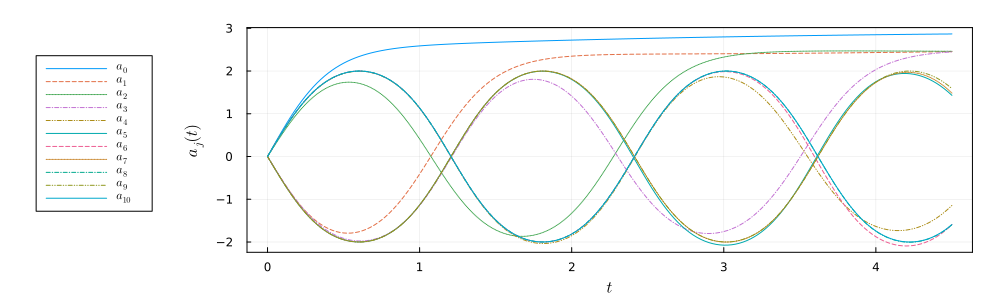

In [59]:
p1

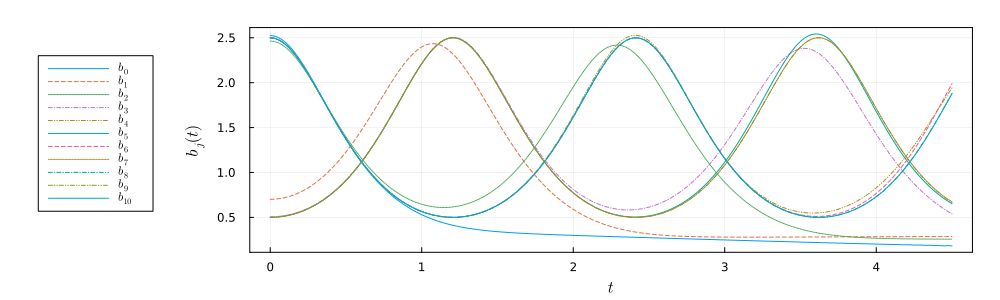

In [60]:
p2

In [61]:
tvec = 0:0.025:4.5
amat17 = zeros(length(tvec)); bmat17 = zeros(length(tvec))
for (j,t) in enumerate(tvec)
    h(j) = x -> exp(t*x)
    (avec,bvec) = get_coeffs(bands,117,"T",h)
    amat17[j] = avec
    bmat17[j] = bvec
end

1.6049433993194391e-12
6.0273329265075924e-15
1.8372211576463727e-12
2.09110984099079e-13
3.319123878443145e-12
-1.88209648368351e-13
1.0243801855981097e-12
-6.450569812165876e-14
1.945506267116602e-12
2.3239877080117936e-13
-7.846531361303741e-12
4.06373639140768e-14
4.582378069282357e-12
6.341717838928131e-14
-5.2138328306860054e-12
-2.3051132084114508e-14
2.9253945603998895e-12
-2.1204434855844284e-13
-3.155786679909077e-12
-7.362130837384466e-13
-7.470625157631979e-12
-1.2326782940647884e-12
2.6747531436883872e-12
-2.3961827975803483e-13
-7.861795323184058e-12
6.019139608418837e-13
-1.3661755010410465e-11
-1.627635176728003e-14
-1.4743615044780452e-11
-8.980418467966438e-15
-1.020893136340427e-11
1.691583344618223e-13
-3.97177609867664e-12
-1.8340429518410294e-13
4.3365038953817846e-12
-2.0688602018927845e-13
2.9104390119657755e-12
1.1146680978630155e-13
-3.232105425263901e-12
-3.482216054196527e-13
5.448716711524243e-12
1.252784809056372e-13
6.4885606573585765e-12
-2.9393591180029

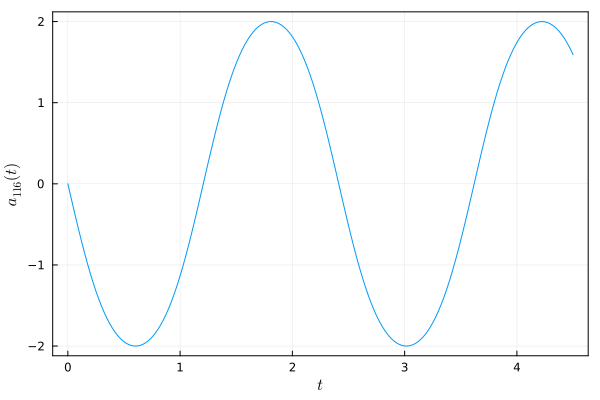

In [62]:
plot(tvec,amat17,label=:false,framestyle=:box)
xlabel!(L"t")
ylabel!(L"a_{116}(t)")

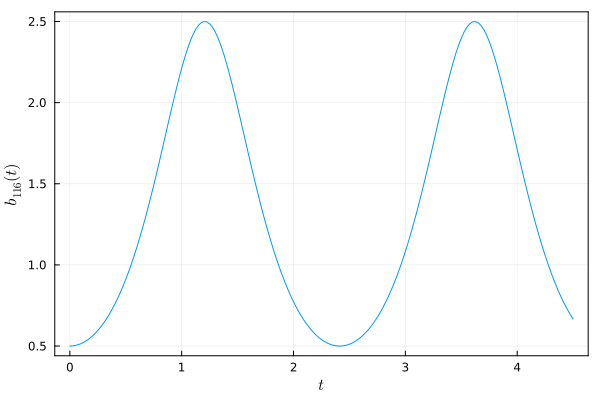

In [63]:
plot(tvec,bmat17,label=:false,framestyle=:box)
xlabel!(L"t")
ylabel!(L"b_{116}(t)")

### Triple interval

In [64]:
bands = [0.1 1.1; 2.0 3.0; 3.5 4.0]

3×2 Matrix{Float64}:
 0.1  1.1
 2.0  3.0
 3.5  4.0

In [65]:
(avec,bvec) = get_n_coeffs(bands,50,"W")

([1.76499999999993, 1.8625129190104217, 2.3487934567094317, 1.4757953769412737, 2.471323517224157, 2.2330553479532043, 1.4962418358371807, 2.5210871219454654, 1.81068652959537, 2.1967819276365272  …  1.8846547332846044, 2.216822190686026, 2.245916172789965, 1.4328644228505851, 2.702446359822073, 1.7717353603838764, 1.970971735738891, 2.1626119457931985, 1.9887087045508922, 2.283524722032568], [1.280634608309508, 1.0192718808046222, 0.6756952880629195, 1.1357574225819609, 0.862907129803706, 1.0609410321444048, 0.7234250796342944, 1.0971488767632718, 1.0663667291510839, 0.6612611570367926  …  1.287782127133284, 0.817498374776115, 0.9414204451732126, 0.897692252303467, 0.9561557804356514, 1.078938362875831, 0.6657011464758529, 1.29601735838828, 0.8402948433412402, 0.852093914863966])

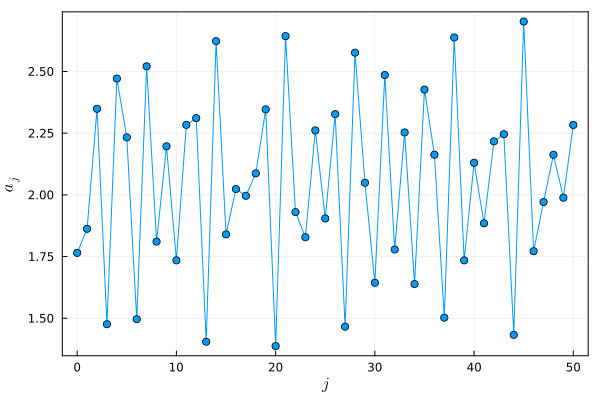

In [66]:
plot(0:50,avec,marker=:circle,legend=:false,framestyle=:box)
xlabel!(L"j")
ylabel!(L"a_j")

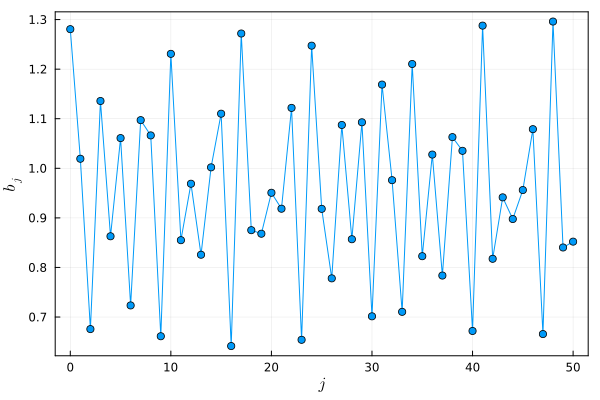

In [67]:
plot(0:50,bvec,marker=:circle,legend=:false,framestyle=:box)
xlabel!(L"j")
ylabel!(L"b_j")

In [68]:
anima = Animation()
animb = Animation()

tvec = 0:0.05:5.7
max_coeffs = 10
amat = zeros(length(tvec),max_coeffs+1); bmat = zeros(length(tvec),max_coeffs+1)
for (j,t) in enumerate(tvec)
    h(j) = x -> exp(t*x)
    (avec,bvec) = get_n_coeffs(bands,max_coeffs,"W",h)
    amat[j,:] = avec
    bmat[j,:] = bvec
    
    plot(0:max_coeffs,avec,seriestype=:scatter,legend=:false)
    ylims!(0, bands[end,2])
    xlabel!(L"j")
    ylabel!(L"a_j")
    title!(L"t=%$t")
    frame(anima)
    
    plot(0:max_coeffs,bvec,seriestype=:scatter,legend=:false)
    ylims!(0, 1.5)
    xlabel!(L"j")
    ylabel!(L"b_j")
    title!(L"t=%$t")
    frame(animb)
end

-1.2878372422103254e-12
-1.0018805976880287e-14
-5.553706043616031e-12
-1.5703982940314403e-13
1.5315076182309967e-12
-1.1114939403959133e-12
-1.760855167539606e-12
9.49155044757345e-15
6.8912337360185535e-12
-9.917842638688742e-14
-1.1648849550297448e-12
5.119299904145641e-14
-2.362258146815203e-12
1.0958528748252555e-12
2.181611325650353e-12
2.0146860209270102e-14
8.248907205332147e-13
3.0390859930894446e-12
-1.1308672891260083e-12
2.335030017546643e-13
-2.611289614678977e-13
2.5464440989895825e-12
1.0052300996921473e-12
-5.735085889863566e-13
-5.9947760094022285e-12
-1.491642176541008e-12
1.2489011555831815e-12
5.321453797927616e-14
-2.8849581066535064e-12
1.4987168853970917e-12
2.9189860172740373e-12
-8.382214870978715e-14
3.2532199589970688e-12
-4.92045351139617e-13
-1.4234862617529203e-12
-1.3158411966022748e-13
-1.4029167024976254e-12
4.787989108860072e-13
1.3277680721038218e-12
-6.08048216135567e-14
4.721160924973103e-11
4.651576256474992e-12
-4.748155414872132e-12
-1.125493673

-1.0286804951057642e-11
-8.544961905013483e-13
1.1381052875576546e-11
-1.9285144070747125e-12
1.4628422049809217e-12
2.6248807171925697e-13
-2.5630315894452577e-12
4.896402120720948e-14
-3.4310185454461985e-11
1.2651829261902464e-11
3.3786253733028475e-11
3.553877970297332e-14
-2.0497465223885923e-11
6.287489891641952e-12
1.0926708672187746e-9
-4.82537514806437e-12
-8.203439441750734e-12
-1.0871337059488672e-13
-1.9406179220942485e-12
4.462525115400652e-13
-8.016133599181913e-12
9.212640778665805e-13
1.0212330597622246e-11
-1.0267920079518438e-12
-3.4627587062836785e-12
-4.0085020872091695e-13
1.7747076508283526e-12
-2.8556554872938946e-13
-1.1441021116236485e-11
9.511917053292631e-12
1.209571513213088e-11
-1.0266346811658886e-12
-1.6944717887702644e-12
2.397622243546398e-13
1.1095081843879533e-11
-1.5992738650502218e-12
3.1925305906376937e-10
-5.016429232029579e-10
1.3703952795303316e-10
2.0103575955804392e-13
1.5213879458976715e-12
4.542773091933693e-13
-5.434088277497685e-12
4.47761

1.8123516266769646e-11
-1.6203085154738114e-12
-3.866604603629288e-11
-3.856597595364585e-12
1.7017828713486227e-11
-1.0470821244035701e-13
-2.0764003014518325e-12
7.747347044599814e-13
-1.4471772731286906e-11
4.398536347131634e-12
2.280058833290984e-8
8.076872680287968e-9
-1.5581425894836734e-9
-9.729513529083125e-13
-1.5318791810500802e-11
9.107967032738236e-12
1.4210909265603035e-11
-2.5759656037264824e-12
2.2791964435509233e-12
-3.00954524122929e-12
1.3542082800568499e-11
-3.896171688336632e-12
2.4937229441960478e-11
-6.866527673362784e-12
-4.105790053391781e-11
-2.812635506792803e-12
-4.084591461989142e-12
1.739022398663861e-13
-1.0678667124199025e-11
4.875366854141544e-12
-3.113523596641542e-8
5.151435398969734e-9
-8.510961447924506e-10
8.01363369328074e-13
5.826538882533684e-12
-9.107655194809431e-13
-1.8056159608396067e-11
6.01938627092679e-13
3.074667853898599e-11
3.6325736167040996e-12
-2.157034654842121e-11
6.256337182002053e-12
2.901812405037451e-11
-8.245346533418374e-12
-

-4.425610489577843e-11
-2.050221363678644e-12
3.50424171865257e-11
-2.8260309016006574e-11
-1.575278076062256e-10
3.742630297791423e-11
1.8002549923855213e-10
1.1045031527502202e-12
2.91035633071415e-11
-2.8242529849883176e-11
-1.9846948480748202e-11
4.3457151870702155e-13
-2.4118717112342006e-11
-6.437336132852651e-12
-1.529325711245113e-11
6.192477151409844e-12
1.1395360703964589e-10
-1.6782443167630288e-11
-6.937739815544117e-8
1.9214926272475264e-9
-3.510883213612368e-10
-2.2401014950771975e-12
-9.686777875405328e-12
7.614187338094026e-13
-7.918925051777331e-13
8.522164618423978e-11
-7.7242344199361e-11
-4.942828064891795e-12
9.99816282721905e-11
6.2293497588815095e-12
-1.0721246332656352e-11
-2.6160932923133602e-12
-4.966369862546244e-12
-1.1466159048773542e-12
2.9023015939239325e-11
-3.1099332905472834e-12
1.2025449381967486e-13
-4.668547086379832e-12
-6.327800061350851e-11
8.723041478584169e-11
2.829179888775713e-7
4.261969559887446e-9
-6.296553979426562e-10
6.0137136910726285e-

2.263979396760211e-10
6.597163450783332e-12
2.6760635261827384e-11
1.8793970892342416e-11
1.1318965416939996e-9
-5.962199979969302e-10
4.977101876572389e-6
-8.522072452476924e-7
1.0137764551974609e-7
5.7403616462259704e-11
-7.719971190708778e-11
1.2762789966936162e-11
3.295787310817905e-10
-1.9520857630260657e-10
3.1163570368455826e-10
-7.018735439495721e-11
-8.366613875134412e-10
-9.389482640315301e-12
2.0242396486243166e-10
-9.232894219144593e-12
-8.442787251214059e-10
3.0787701637487816e-10
9.07278677233063e-10
-2.243661916465824e-11
3.006735843382728e-11
-1.3522603109467862e-11
-1.1756650380993265e-10
7.002420916121376e-10
1.5093193266491794e-5
-3.5428840924542126e-7
4.1131493347329435e-8
1.8066358463194309e-10
9.195626733567523e-12
-8.35984980392502e-12
5.599669734496531e-10
-1.3597652002510176e-10
-4.145384162788494e-10
1.2201950006942823e-11
1.2705824230016071e-10
-2.1071523931059678e-11
-1.926494749637962e-10
1.0548287984524472e-10
1.1546133916354784e-9
4.229986330056403e-11
-1

6.119385648773116e-10
7.183199045517678e-10
2.3048346116542622e-9
-1.0658979100339057e-9
-3.1524421805019635e-9
-3.780040777419756e-11
9.687164944344252e-11
2.033556502562523e-10
-4.3437328806525887e-10
-2.015763725069837e-10
6.370447356536376e-10
4.85591481352516e-11
1.1670235757781115e-10
-9.42585733103238e-11
-2.5075547110115566e-10
1.2089298807524113e-10
-0.00013280310394629482
1.8073172537869718e-6
-1.8104635359029962e-7
2.296381951674894e-9
-3.7578684349992306e-10
-1.4434038719166674e-11
3.7431818062297357e-10
5.572728166254238e-10
-8.056918294273356e-10
3.8378847025710736e-10
2.1134833992977835e-9
-2.057062558095078e-10
-1.330706512249294e-9
8.685141439222571e-12
4.838119930098464e-9
-1.2173488457293676e-9
-4.726083916335648e-9
1.8077827468756234e-10
-2.6755605502206624e-10
1.605790394512621e-11
-1.3707610653781057e-10
-3.8551231493726995e-10
-0.00012523637537171738
3.607649676404875e-5
-3.855374752585842e-6
-4.2137171383639045e-9
-2.1751201757434496e-11
-1.4040552653987204e-10


-5.357991520375135e-10
-1.248847897164022e-8
-4.1832808037368486e-10


┌ Info: Saved animation to 
│   fn = /home/cade/Research/NumericRH/toda3inta.gif
└ @ Plots /home/cade/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/cade/Research/NumericRH/toda3inta.gif")
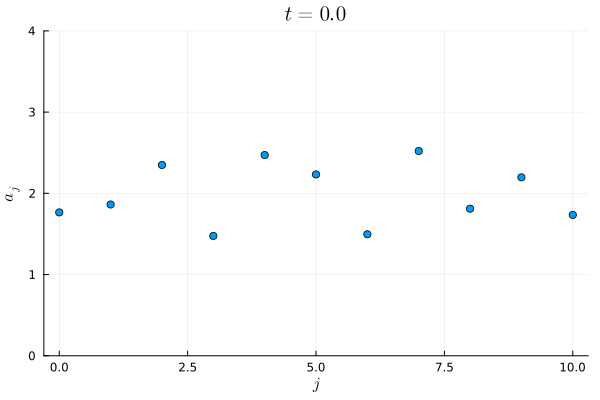

In [69]:
gif(anima,"toda3inta.gif")

┌ Info: Saved animation to 
│   fn = /home/cade/Research/NumericRH/toda3intb.gif
└ @ Plots /home/cade/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/cade/Research/NumericRH/toda3intb.gif")
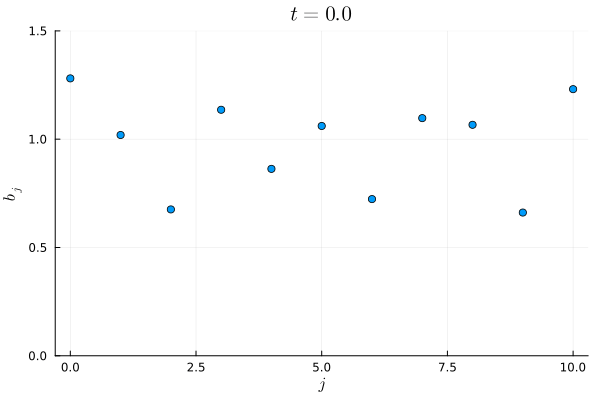

In [70]:
gif(animb,"toda3intb.gif")

In [71]:
p1 = plot(legend=:outerleft,size=(1000,300),framestyle=:box,margin=5Plots.mm)
xlabel!(L"t")
ylabel!(L"a_j(t)")

p2 = plot(legend=:outerleft,size=(1000,300),framestyle=:box,margin=5Plots.mm)
xlabel!(L"t")
ylabel!(L"b_j(t)")

for j = 0:max_coeffs
    plot!(p1,tvec,amat[:,j+1],label=L"a_{%$j}",linestyle=styles[j%5+1])
end

for j = 0:max_coeffs
    plot!(p2,tvec,bmat[:,j+1],label=L"b_{%$j}",linestyle=styles[j%5+1])
end

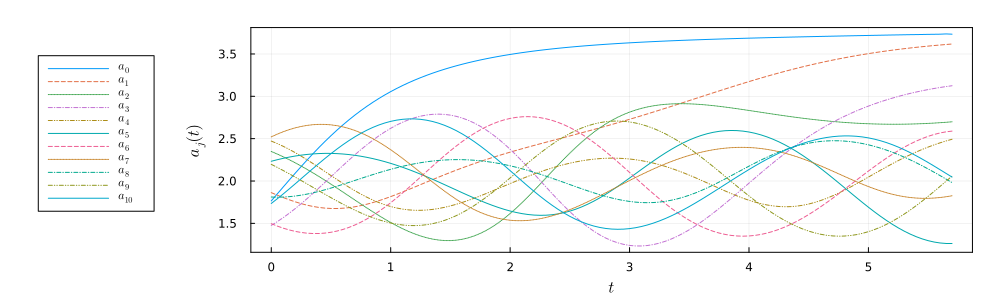

In [72]:
p1

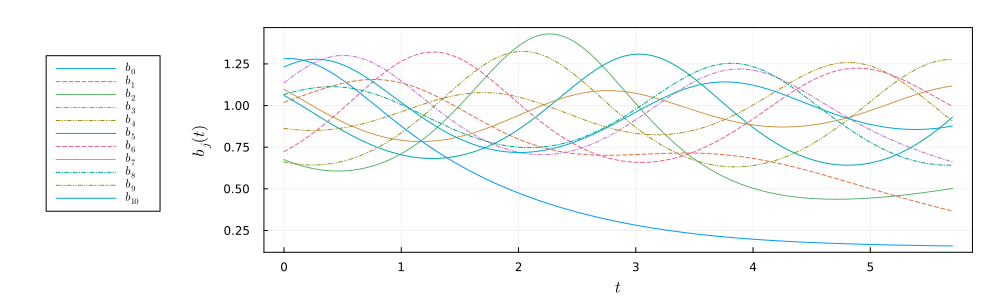

In [73]:
p2

# Compute Cauchy Integral at zero

In [94]:
bands = [-4.5 -3.0; -2.0 -1.0; 2.0 3.0]
g = size(bands,1)-1

2

In [95]:
@time (avec,bvec,ints,g₀)=get_n_coeffs_and_ints(bands,100,0.0);

  2.652663 seconds (4.00 M allocations: 2.939 GiB, 3.15% gc time)


In [96]:
function ComputeOrthoPoly(x, avec, bvec)
    N = length(bvec)-1
    p = zeros(N+1)
    p[1] = 1
    p[2] = (x-avec[1])*p[1]/bvec[1]
    for j = 2:N
        p[j+1] = -(bvec[j-1]*p[j-1]+(avec[j]-x)*p[j])/bvec[j]
    end
    p
end

ComputeOrthoPoly (generic function with 1 method)

In [97]:
approx_coeffs = real.(ints*(2im/(g+1)));

In [98]:
xvec = [bands[1,1]:0.01:bands[1,2]; bands[2,1]:0.01:bands[2,2]; bands[3,1]:0.01:bands[3,2]]
ftrue = 1.0./xvec; #true values of 1/x

In [99]:
# use j polynomials to approximate 1/x
valsfunc(j) = map(x -> sum(ComputeOrthoPoly(x,avec[1:j],bvec[1:j]).*approx_coeffs[1:j]),xvec)

valsfunc (generic function with 1 method)

In [100]:
maxpolys = 85
errvec = map(j -> maximum(abs.(valsfunc(j)-ftrue)),2:maxpolys+1);

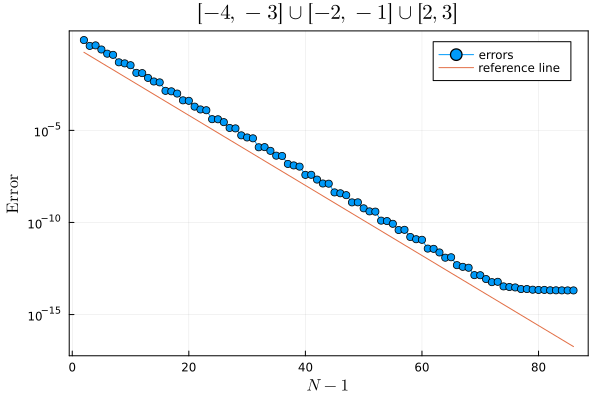

In [110]:
plot(2:maxpolys+1,errvec,yaxis=:log,marker=:circle,label="errors",framestyle=:box)
xlabel!(L"N-1")
ylabel!(L"\mathrm{Error}")
yticks!([10^-5, 10^-10, 10^-15])
plot!(2:maxpolys+1,abs.(exp.(-g₀.*(2.0.+(2:maxpolys+1)))),label="reference line")
title!(L"[-4, -3]\cup[-2, -1]\cup[2, 3]")

### A case where $0$ is not in the gaps for comparison

In [111]:
bands = [1.0 2.3; 3.0 4.0; 4.5 6.1]

3×2 Matrix{Float64}:
 1.0  2.3
 3.0  4.0
 4.5  6.1

In [112]:
@time (avec,bvec,ints,g₀)=get_n_coeffs_and_ints(bands,100,0.0);

  2.688051 seconds (4.32 M allocations: 2.949 GiB, 3.36% gc time)


In [113]:
xvec = [bands[1,1]:0.01:bands[1,2]; bands[2,1]:0.01:bands[2,2]; bands[3,1]:0.01:bands[3,2]]
ftrue = 1.0./xvec; #true values of 1/x

In [114]:
approx_coeffs = real.(ints*(2im/(g+1)));

In [115]:
# use j polynomials to approximate 1/x
valsfunc(j) = map(x -> sum(ComputeOrthoPoly(x,avec[1:j],bvec[1:j]).*approx_coeffs[1:j]),xvec)

valsfunc (generic function with 1 method)

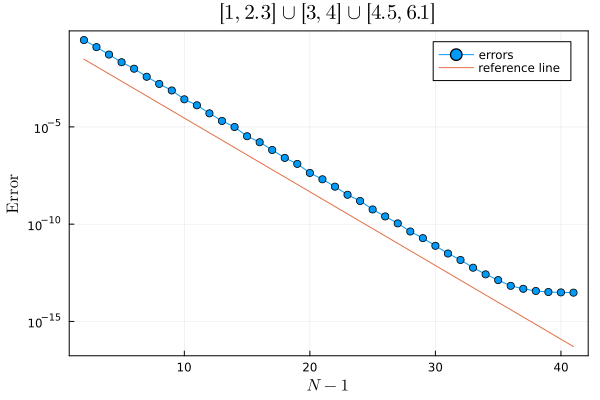

In [116]:
maxpolys = 40
errvec = map(j -> maximum(abs.(valsfunc(j)-ftrue)),2:maxpolys+1)
plot(2:maxpolys+1,errvec,yaxis=:log,marker=:circle,label="errors",framestyle=:box)
xlabel!(L"N-1")
ylabel!(L"\mathrm{Error}")
plot!(2:maxpolys+1,abs.(exp.(-g₀.*(2.0.+(2:maxpolys+1)))),label="reference line")
title!(L"[1, 2.3]\cup[3, 4]\cup[4.5, 6.1]")